# What Makes a Good Doctor ?

## Text Analysis of Doctor Reviews Using Fisher's Discriminant, LDA and Word Embedding

Patients are increasingly turning to patient review sites when looking for new doctors. While patient reviews might not reflect the full range of experiences that a doctor provides, it is important for doctors to know what experiences patients cite when giving either good or bad reviews. 



---


Contributors: Sonal Agrawal, Jingyao Kang, Laura Klipp, Rahul Panicker

#### Background and Data Collection

Patient reviews were scraped from the two most frequently studied patient review websites, Ratemds.com and Healthgrades.com. Data was scraped for multiple specialties in various cities around the United States. 

Reviews were scraped for the following 6 specialties:
 - Family Doctors / General Practitioners   |   Internal Medicine   |   General Surgery   |  Cardiology   |   OBGYN   |   Pediatrics

Reviews were scraped in the following 5 cities:
 - Los Angeles   |    Houston   |    Atlanta   |   Detroit  |   Seattle

In [1]:
# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

NameError: name 'reload' is not defined

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np   
import nltk 
import string
import os
import gensim
from gensim import corpora
import pyLDAvis.gensim
nltk.download('stopwords')

from collections import Counter
import matplotlib.pyplot as pyplot
import seaborn as sns
import matplotlib.colors as mcolors

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings("ignore")                                   #Ignoring unnecessory warnings

from wordcloud import WordCloud
from nltk.corpus import stopwords                                   #Stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer                                 # Stemmer
from nltk.stem import WordNetLemmatizer                             # Lemmatizer
#nltk.download('punkt')
nltk.download('stopwords')

ModuleNotFoundError: No module named 'gensim'

In [3]:
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF 

#### Data Cleaning
* Import all scrapes from each specialty and combine them 
* Only keep the star rating from the review and the review
* Subset the data only for the good reviews (4 stars and above) and the bad reviews (3 stars and below)
* Make a dummy column of the good and bad reviews
* Make two new df of good and bad reviews

In [5]:
# Cardiologists
dfCard1 = pd.read_csv("https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Cardiologist_Hou.csv", index_col ='Unnamed: 0')
dfCard2 = pd.read_csv("https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Cardiologist_LA.csv", index_col ='Unnamed: 0')
dfCard3 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Cardiologist_Atl.csv', index_col ='Unnamed: 0')
dfCard4 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Cardiologist_Sea.csv', index_col ='Unnamed: 0')
dfCard5 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Cardiologist_Det.csv', index_col ='Unnamed: 0')
dfCard6 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/Healthgrades_Cardiologist_Hou.csv', sep = '\t', index_col ='Unnamed: 0')

# Family General Practitioners
dfGP1 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Family_GP_Atl.csv', index_col ='Unnamed: 0')
dfGP2 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Family_GP_Hou.csv', index_col ='Unnamed: 0')
dfGP3 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Family_GP_LA.csv', index_col ='Unnamed: 0')
dfGP4 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Family_GP_Sea.csv', index_col ='Unnamed: 0')
dfGP5 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Family_GP_Det.csv', index_col ='Unnamed: 0')
dfGP6 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/Healthgrades_Family_GP_Hou.csv', sep = '\t', index_col ='Unnamed: 0')

# Internal Medicine
dfInt1 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Intern_Atl.csv', index_col ='Unnamed: 0')
dfInt2 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Intern_Hou.csv', index_col ='Unnamed: 0')
dfInt3 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Intern_LA.csv', index_col ='Unnamed: 0')
dfInt4 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Intern_Sea.csv', index_col ='Unnamed: 0')
dfInt5 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Intern_Det.csv', index_col ='Unnamed: 0')
dfInt6 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/Healthgrades_Intern_Hou.csv', sep = '\t', index_col ='Unnamed: 0')

# Pediatrics
dfPed1 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Ped_Atl.csv', index_col ='Unnamed: 0')
dfPed2 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Ped_Hou.csv', index_col ='Unnamed: 0')
dfPed3 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Ped_LA.csv', index_col ='Unnamed: 0')
dfPed4 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Ped_Sea.csv', index_col ='Unnamed: 0')
dfPed5 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Ped_Det.csv', index_col ='Unnamed: 0')
dfPed6 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/Healthgrades_Ped_Hou.csv', sep = '\t', index_col ='Unnamed: 0')

# General Surgery
dfSurg1 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Surgery_Atl.csv', index_col ='Unnamed: 0')
dfSurg2 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Surgery_Hou.csv', index_col ='Unnamed: 0')
dfSurg3 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Surgery_LA.csv', index_col ='Unnamed: 0')
dfSurg4 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Surgery_Sea.csv', index_col ='Unnamed: 0')
dfSurg5 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_Surgery_Det.csv', index_col ='Unnamed: 0')
dfSurg6 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/Healthgrades_Surgery_Hou.csv', sep = '\t', index_col ='Unnamed: 0')

# OBGYN
dfOB1 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_OBGYN_Atl.csv', index_col ='Unnamed: 0')
dfOB2 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_OBGYN_Hou.csv', index_col ='Unnamed: 0')
dfOB3 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_OBGYN_LA.csv', index_col ='Unnamed: 0')
dfOB4 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_OBGYN_Sea.csv', index_col ='Unnamed: 0')
dfOB5 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/RateMD_OBGYN_Det.csv', index_col ='Unnamed: 0')
dfOB6 = pd.read_csv('https://raw.githubusercontent.com/KlippL/Doctors_Reviews_NLP/master/Doctor_reviews/Healthgrades_OBGYN_Hou.csv', sep = '\t', index_col ='Unnamed: 0')

In [6]:
df_cardio = pd.concat([dfCard1, dfCard2, dfCard3, dfCard4, dfCard5, dfCard6],ignore_index=True, sort=True)
df_gp = pd.concat([dfGP1, dfGP2, dfGP3, dfGP4, dfGP5, dfGP6],ignore_index=True, sort=True)
df_intern = pd.concat([dfInt1, dfInt2, dfInt3, dfInt4, dfInt5, dfInt6],ignore_index=True, sort=True)
df_ped = pd.concat([dfPed1, dfPed2, dfPed3, dfPed4, dfPed5, dfPed6],ignore_index=True, sort=True)
df_surg = pd.concat([dfSurg1, dfSurg2, dfSurg3, dfSurg4, dfSurg5, dfSurg6],ignore_index=True, sort=True)
df_ob = pd.concat([dfOB1, dfOB2, dfOB3, dfOB4, dfOB5, dfOB6],ignore_index=True, sort=True)

df_a = pd.concat([df_cardio, df_gp, df_intern, df_ped, df_surg, df_ob], ignore_index=True, sort=True)

df_a = df_a[df_a.review.notnull()]
df_a = df_a[df_a.review != "None"]

print (len(df_a))

df_a.head()

17635


city         doctor_name gender  helpfullness_rating  \
0  Angleton  Dr. Mohammed Attar   Male                  5.0   
1  Angleton  Dr. Mohammed Attar   Male                  5.0   
2  Angleton  Dr. Mohammed Attar   Male                  5.0   
3  Angleton  Dr. Mohammed Attar   Male                  5.0   
4  Angleton  Dr. Mohammed Attar   Male                  5.0   

  helpfulness_rating individual_rating knowledge_rating overall_rating  \
0                NaN                 5                5           4.93   
1                NaN                 5                5           4.93   
2                NaN                 5                5           4.93   
3                NaN                 5                5           4.93   
4                NaN                 5                5           4.93   

                                              review review_count  \
0  I was assigned Dr Attar in the Methodist ER. H...           21   
1  His kindness and caring gave me the sense that...           21   
2  He was my cardiologist when I used to live in ...           21   
3  Dr.Attar is the best Dr anywhere, i love him t...           21   
4  The doctor who was sent to us from god. He is ...           21   

                review_date scheduling_rating     specialty staff_rating  \
0  2017-12-15T00:55:45.983Z               NaN  cardiologist            5   
1  2016-08-30T05:07:29.955Z               NaN  Cardiologist            5   
2  2016-06-19T09:41:34.719Z               NaN  Cardiologist            5   
3  2016-03-30T02:20:23.272Z               NaN  Cardiologist            5   
4  2014-09-10T00:46:59.381Z               NaN  Cardiologist            5   

   state wait_time  wait_time_rating  
0  Texas       NaN               5.0  
1  Texas       NaN               5.0  
2  Texas       NaN               5.0  
3  Texas       NaN               5.0  
4  Texas       NaN               5.0

In [7]:
## The distribution of review ratings
df_a['individual_rating'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    colors = 'cadetblue',
    yTitle='count',
    title='Review Rating Distribution')

AttributeError: 'Series' object has no attribute 'iplot'

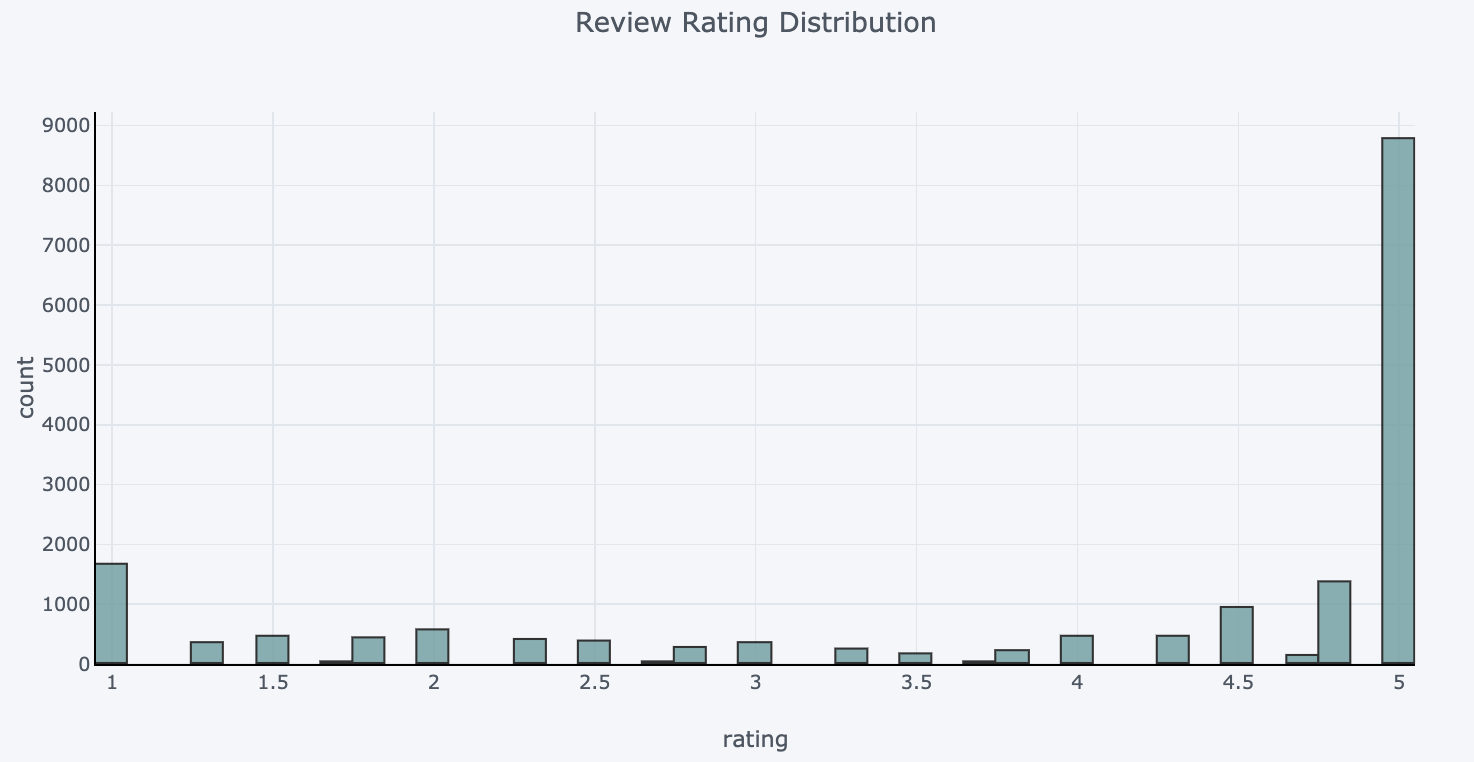

In [7]:
# Filter the reviews based on reviews having a score of 4 or more and less than 3
df_all = df_a[['individual_rating', 'review']]
df_all.individual_rating = df_all.individual_rating.astype(float)
df_all = df_all[(df_all.individual_rating >= 4) | (df_all.individual_rating < 3)]

# Make a separate df of good reviews and bad reviews
df_good = df_all[(df_all.individual_rating >= 4)]
df_bad = df_all[(df_all.individual_rating < 3)]

# Make a dummy column in df_all for if a review is good or bad
df_all['is_good'] = (df_all.individual_rating >= 4) * 1 + (df_all.individual_rating < 3) * 0

print("Number of good reviews: ")  
(df_all['is_good'] == 1).sum()
print(' ')
print(" Number of bad reviews:") 
(df_all['is_good'] == 0).sum()

12135

4526

In [8]:
## The distribution review text lengths
df_all['word_count'] = df_all['review'].apply(lambda x: len(str(x).split()))
df_all_words = df_all[df_all.word_count < 500]

## The distribution review text lengths
df_all_words['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    colors = 'cadetblue',
    yTitle='count',
    title='Review Text Word Count Distribution')

AttributeError: 'Series' object has no attribute 'iplot'

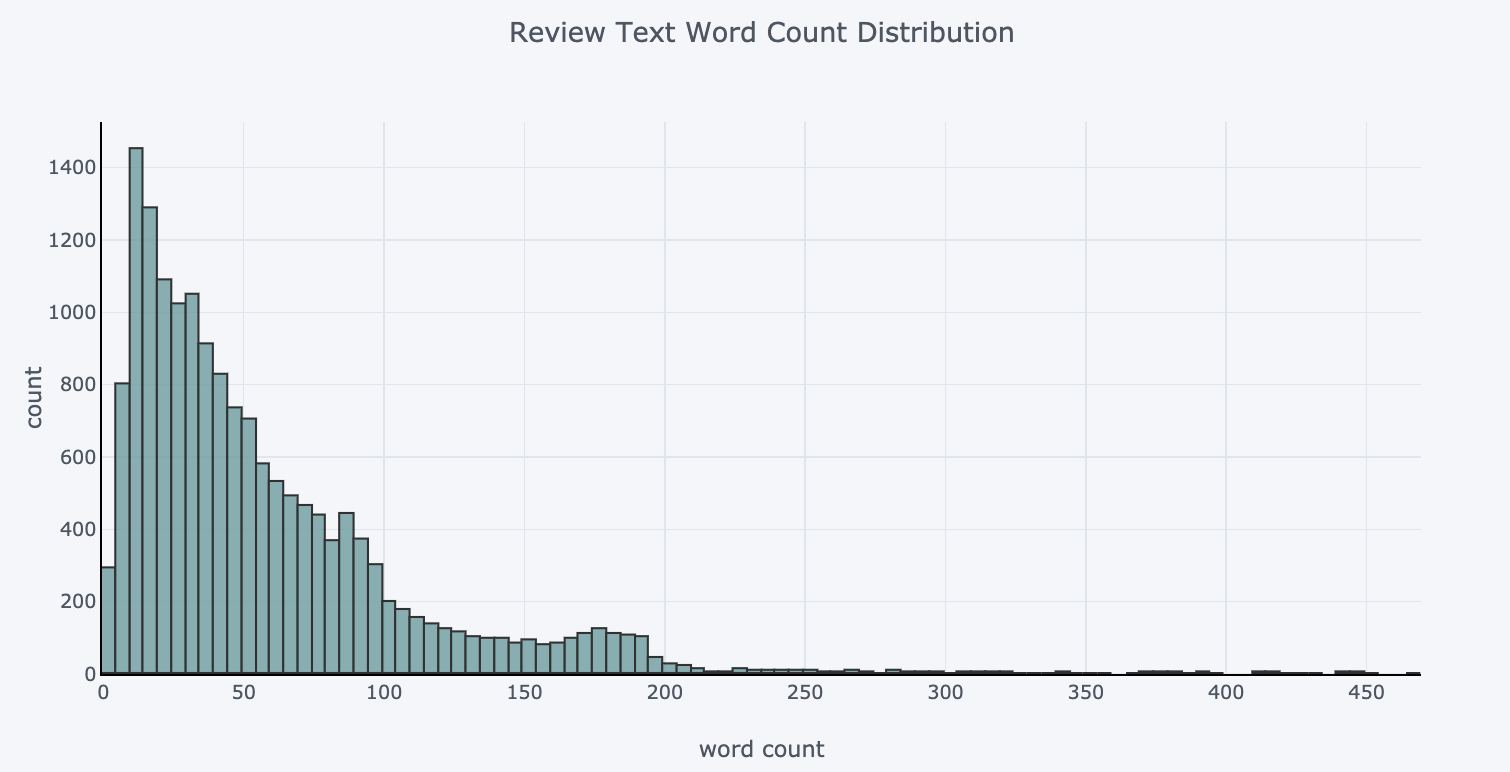

In [9]:
random_sub = df_all.sample(n=12500, random_state = 2)
random_sub.head()

print("Number of good reviews: ")  
(random_sub['is_good'] == 1).sum()
print(' ')
print(" Number of bad reviews:") 
(random_sub['is_good'] == 0).sum()

individual_rating                                             review  \
14529                5.0  LOVE, LOVE, LOVE Dr Sharon!! BEST DOCTOR EVER!...   
5864                 1.0  due to rain/traffic I was exactly 12 mins late...   
18041                4.8  Best Doc in the world! I've known Dr. Zipkin f...   
4825                 4.5  I LOVE Dr McCaleb! She is THE Best and no one ...   
18520                5.0  She is a fantastic Dr..helpful..caring and ver...   

       is_good  word_count  
14529        1         126  
5864         0         101  
18041        1          22  
4825         1          16  
18520        1           8

9137

3363

#### Dataset Overview
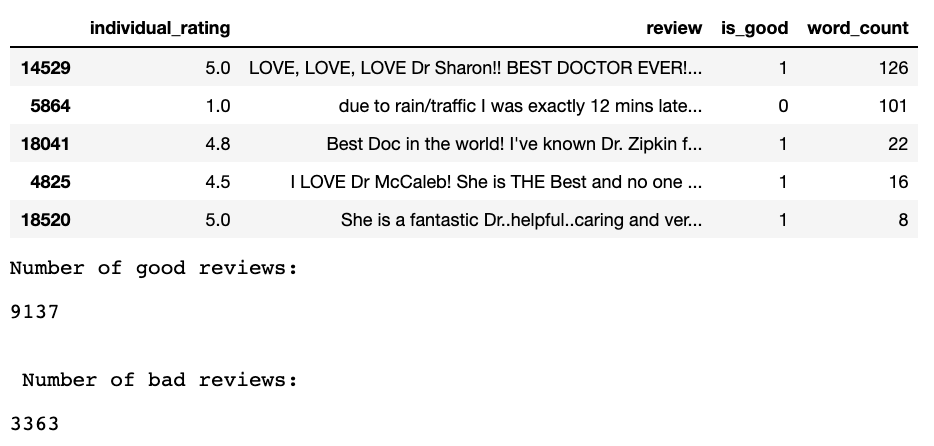

### Define Cleaning Functions

In [10]:
# Remove Punctuation
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c,"")
    return s

def removePunc(text_array):
    nopunc = []
    for h in text_array:
        try:
            nopunc.append(removePuncStr(h))
        except:
            nopunc.append(h)
    return nopunc

# Remove Numbers
def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s

def removeNumbers(text_array):
    nonum = []
    for n in text_array:
        try:
            nonum.append(removeNumbersStr(n))
        except:
            nonum.append(i)
    return nonum

# Remove Stopwords
def stopText(text_array):
    stop_words = set(stopwords.words('english'))
    stopped_text = []
    for h in text_array:
        try:
            words = word_tokenize(h)
            h2 = ''
            for w in words:
                if w not in stop_words:
                    h2 = h2 + ' ' + w
            stopped_text.append(h2)
        except:
            stopped_text.append(h)
    return stopped_text


# Lemmentization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

def lemmText(text_array):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for h in text_array:
        try:
            words = word_tokenize(h) 
            h2 = ''
            for w in words:
                h2 = h2 + ' ' + WNlemmatizer.lemmatize(w,pos="v")
            lemmatized_text.append(h2)
        except:
            lemmatized_text.append(h)
    return lemmatized_text

# Removing other words that don't impact reviews
def stopOther(text_array):
    stop_words = set(['as','dr', 'he_is', 'said', 'told', 'did_not', 'another', 'didnt', \
                      'and_then', 'to_be','would', 'get', 'go', 'even', 'takes', 'at_all', 'doesnt', 'is_not', \
                      'about_it', 'about', 'across', 'act', 'acts', 'two', 'back', 'dont', 'patient', 'office', \
                      'of_the', 'in_the', 'one', 'also', 'have_been', 'always', 'he_has', 'like', 'see', 'and_his', \
                      'of_my', 'one_of', 'is_the', 'going', 'first', 'is_very', 'anyone', 'could', 'really', 'him_to'\
                      'to_the', 'and_he', 'has_been', 'in_his', 'to_see', 'went', 'for_the', 'in_my', 'she_is', \
                      'if_you', 'way', 'many', 'hes', 'since', 'to_me', 'and_the', 'that_he', 'is_an', 'me_and', \
                      'ive', 'say', 'man', 'him_and', 'with_my', 'to_him', 'of_his', 'and_was', 'on_the', 'with_the', \
                      'with_me', 'with_his', 'second', 'much', 'of_dr', 'im', 'to_have', 'and_my', 'at_the', 'as_well', \
                      'done', 'for_my', 'to_my', 'was_very', 'the_doctor', 'me_to', 'and_very', 'it_is', 'and_have', \
                      'ago', 'to_get', 'houston', 'sure', 'you_are', 'the_most', 'for_his', 'to_dr', 'and_has', \
                      'would_not', 'saw', 'doctor_he', 'it_was', 'had_to', 'is_one', 'going_to', 'for_over', 'that_was', \
                      'thorough_and', 'us', 'able_to', 'out_of', 'he_says', 'will', 'he_was', 'ever', 'him_to', \
                      'to_the', 'make', 'took', 'made', 'he_is_very', 'care_of', 'with_dr', 'things', 'go_to', 'came', \
                      'without', 'see_him', 'been_my', 'every', 'about_his', 'is_one_of', 'to_his', 'put', 'to_make', \
                      'for_me', 'have_to', 'may', 'all_of', 'and_is', 'with_him', 'would_have', 'to_take', 'to_you', \
                      'he_is_the', 'does_not', 'with_you', 'he_did', 'him_for', 'all_the', 'have_had', 'his_time', \
                      'you_have', 'want', 'what_is', 'seems', 'doctor_is', 'and_they', 'lot', 'to_go', 'went_to', \
                      'not_be', 'from_the', 'was_in', 'to_do', 'three', 'but_he', 'one_of_the', 'several', 'for_him', \
                      'and_takes', 'takes_the', 'is_one_of_the', 'he_will', 'actually', 'not_only', 'she_was', \
                      'he_takes', 'md', 'he_is_more', 'who_is', 'was_not', 'he_should', 'he_sent', 'he_was_more', \
                      'health_the', 'heard_of', 'he_was_so', 'he_was_our', 'he_was_on', 'he_put_in', 'he_is_now', \
                      'he_is_part', 'he_is_really', 'he_is_just', 'he_is_in', 'he_only', 'he_not_only', 'he_needed_to', \
                      'he_may', 'he_just', 'he_knew_the', 'he_worked', 'he_works', 'he_wrote', 'head_now', \
                      'he_is_one_the', 'he_is_now_my', 'he_is_in_this', 'he_is_able_to', 'he_is_able_to_do', \
                      'he_is_able', 'he_is_doing_and', 'he_needed', 'he_only_has', 'year', 'years', 'got', 'to_this',\
                      'do_not', 'and_had', 'me_that', 'this_is', 'at_me', 'of_this', 'the_is', 'to_come', 'wont', \
                      'this_was', 'she_had', 'to_to', 'that_had', 'then_she', 'in_for', 'me_for', 'is_of', 'for_an', \
                      'and_when', 'with_this', 'she_is_very', 'because_of', 'am_not', 'and_did_not', 'she_and_her', \
                      'this_and', 'him_again_and', 'her_very', 'take_those', 'on_all', 'them_not', 'at_the_same',\
                      'you_from', 'you_out_of', 'and_sometimes', 'when_he_was', 'that_in', 'but_we', 'with_our', \
                      'each_other', 'for_in', 'and_he_is_the', 'he_give', 'and_over', 'only_is', 'when_there', \
                      'have_in', 'have_he', 'that_have_been', 'has_an', 'there_he', 'but_what', 'who_have', 'yr', \
                      'there_is', 'out_of_his', 'him_when', 'in_addition', 'and_he_was', 'before_he', 'no_matter', \
                      'her_with', 'be_my', 'he_is_doing', 'tx', 'for_yrs', 'can_be', 'any_other', 'with_your', \
                      'rest_of', 'know_he', 'that_know', 'with_any', 'few_and',  'me_and_was', 'did_my', 'but_she_is', \
                      'think_the', 'and_know', 'they_take', 'yrs_and', 'for_their', 'for_being', 'with_her', 'she_has', \
                      'medical', 'never', 'pysician', 'now', 'day', 'seen', 'cardiologist', 'need', 'tell', 'work', \
                      'patients', 'to_how', 'lots', 'what_should', 'and_not', 'you_to', 'on_my', 'was_the', 'she_did',\
                      'that_the', 'had_no', 'to_her', 'and_she', 'shes', 'her_to', 'and_her', 'that_she', 'they_are', 'her_she', \
                      'not_to', 'and_that', 'for_and', 'in_her', 'more_than', 'her_for', "\'", "\"", "'", 'hare', 'nd', 'c', \
                      'de', 'u', 'la', 'moore', 'parker'
                     ])
    stopped_text = []
    for h in text_array:
        try:
            words = word_tokenize(h)
            h2 = ''
            for w in words:
                if w not in stop_words:
                    h2 = h2 + ' ' + w
            stopped_text.append(h2)
        except:
            stopped_text.append(h)
    return stopped_text

### Generating Word Clouds  to Find differences in words that are used in good and bad reviews

Word clouds for total reviews, good reviews, and bad reviews shows differences in word frequencies between good and bad reviews. We can see that certain words appear in both the good and bad reviews such as *time* and *staff*. These are general words that we will later explore why these words are importand in both categories of reviews. 

In [11]:
# Clean all reviews 
reviews_all = df_all.review.str.lower()
reviews_all = removePunc(reviews_all)
reviews_all = removeNumbers(reviews_all)
reviews_all = stopText(reviews_all)
reviews_all = stopOther(reviews_all)

# Word Cloud for all reviews
wordcloud = WordCloud().generate(pd.Series(reviews_all).str.cat(sep = " "))

pyplot.figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

NameError: global name 'stopwords' is not defined

#### All Reviews
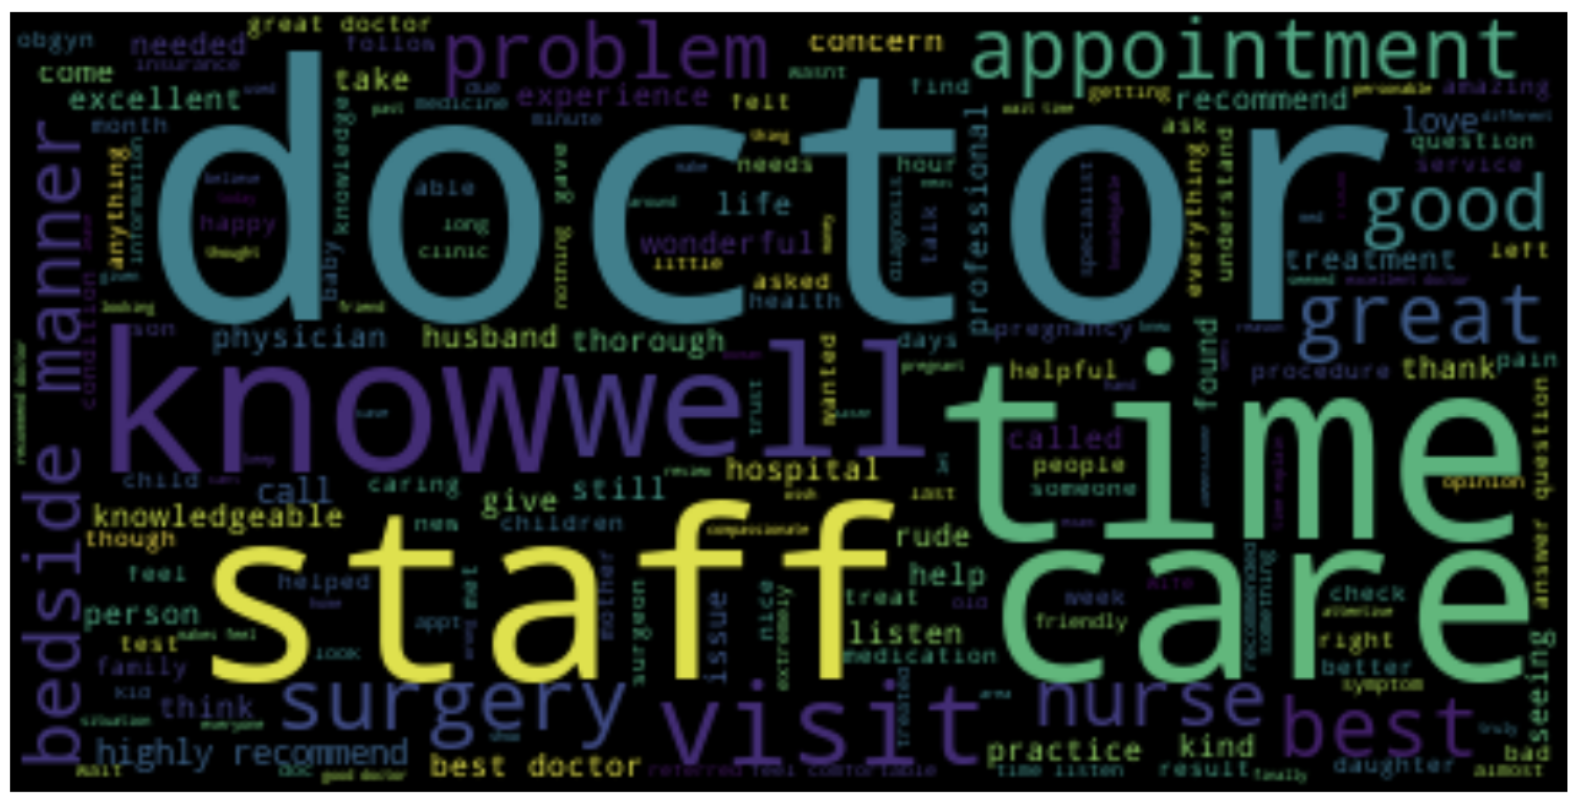

In [12]:
# Clean good reviews
reviews_good = df_good.review.str.lower()
reviews_good = removePunc(reviews_good)
reviews_good = removeNumbers(reviews_good)
reviews_good = stopText(reviews_good)
reviews_good = stopOther(reviews_good)
wordcloud = WordCloud().generate(pd.Series(reviews_good).str.cat(sep = " "))

# Word Cloud for good reviews
pyplot.figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

NameError: global name 'stopwords' is not defined

#### Good Reviews
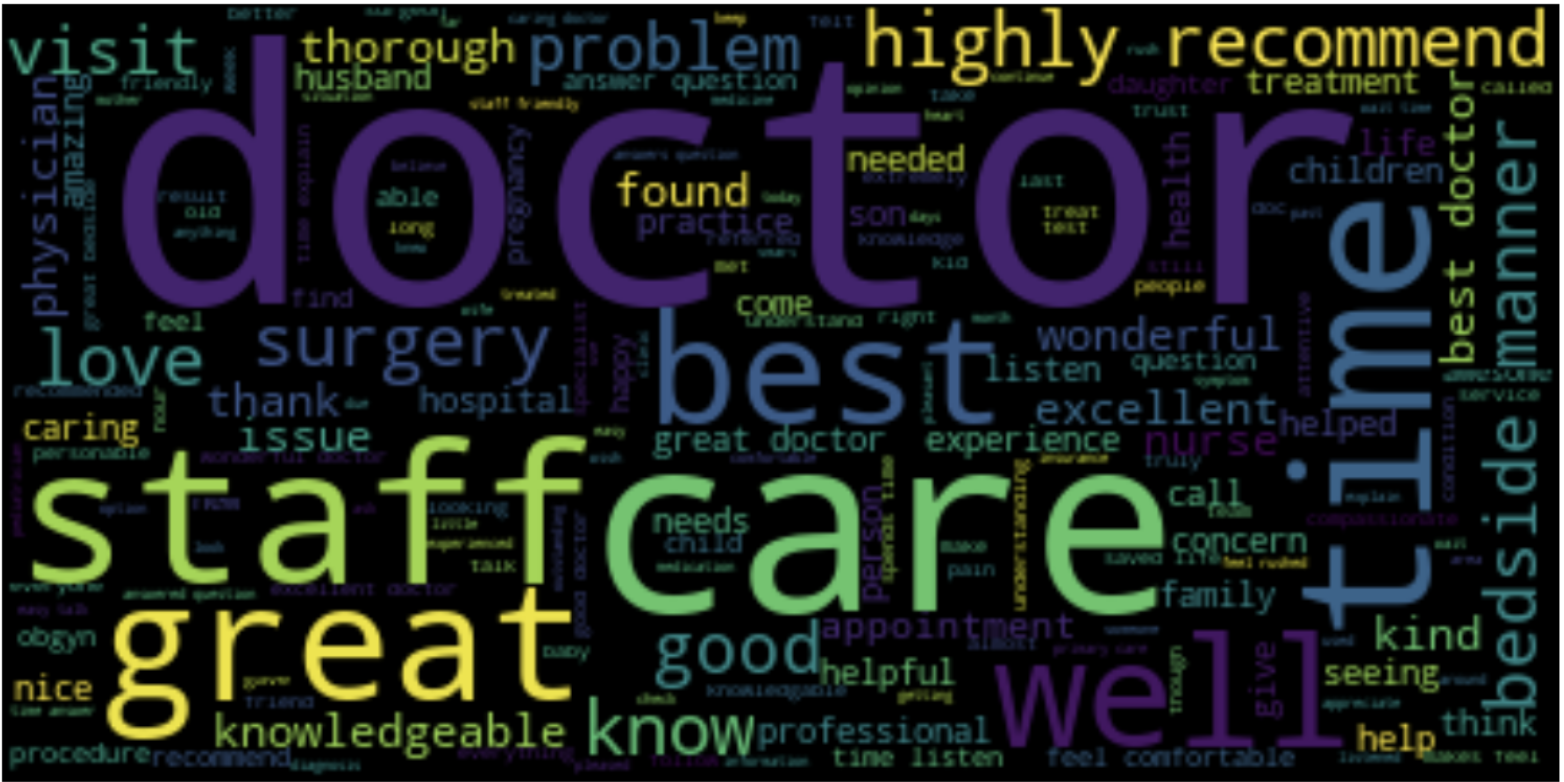

In [13]:
# Clean bad reviews
reviews_bad = df_bad.review.str.lower()
reviews_bad = removePunc(reviews_bad)
reviews_bad = removeNumbers(reviews_bad)
reviews_bad = stopText(reviews_bad)
reviews_bad = stopOther(reviews_bad)

# Word Cloud for bad reviews
wordcloud = WordCloud().generate(pd.Series(reviews_bad).str.cat(sep = " "))

pyplot.figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

NameError: global name 'stopwords' is not defined

#### Bad Reviews
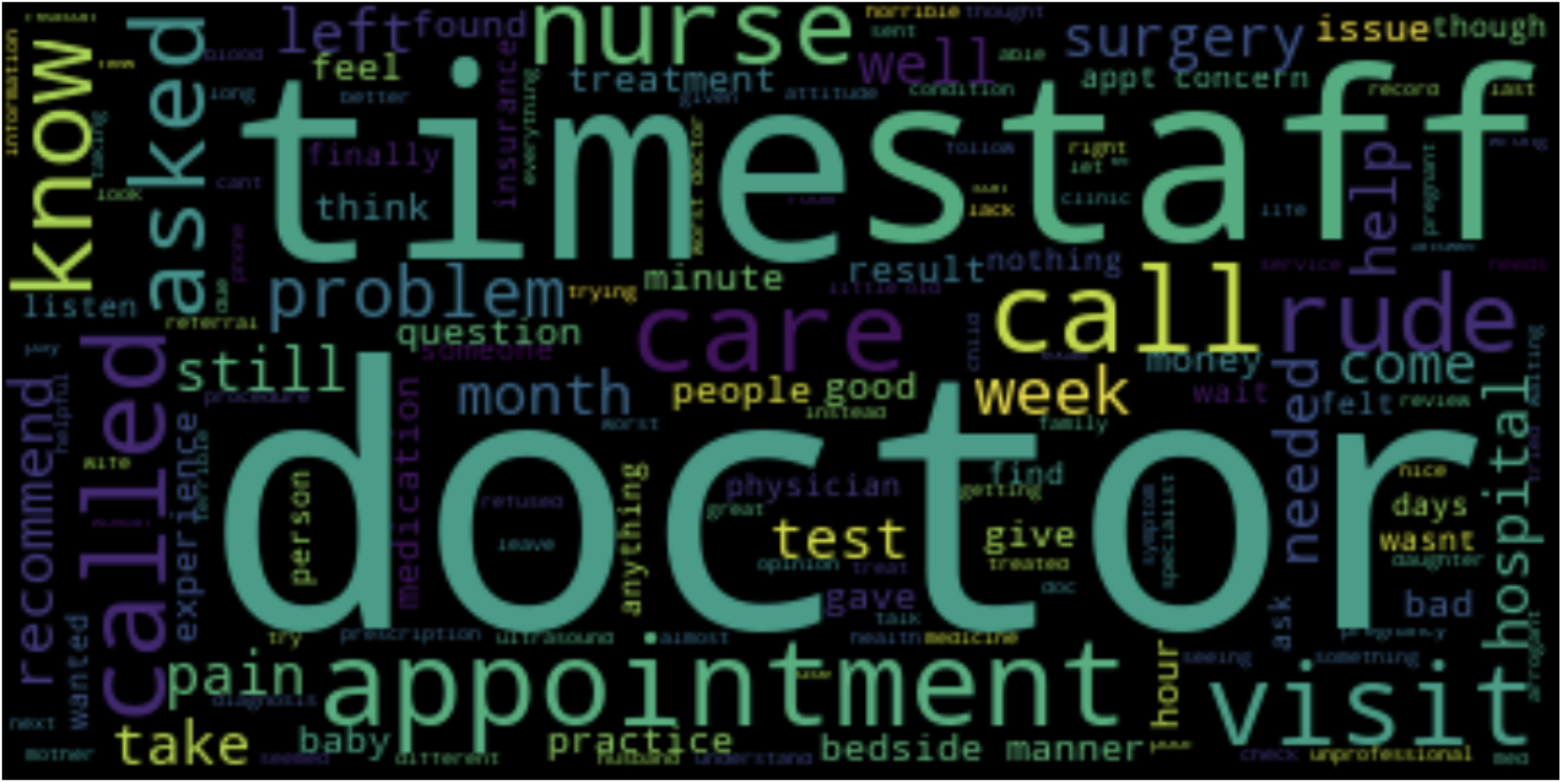

## Text Analysis

1. Create a Term Review Matrix of Terms and N-Grams
2. Find the top 15 words that appear in all reviews
3. Find the top 15 phrases that appear in all reviews
4. Find the top 15 most descriminating words or phrases that determine good and bad reviews using Fisher's Discriminant Score

#### Create a Term Review Matrix of Terms and N-Grams

In [ ]:
reviews_sub = random_sub.review.str.lower()
reviews_sub = removePunc(reviews_sub)
reviews_sub = removeNumbers(reviews_sub)
reviews_sub = stopOther(str(reviews_sub))

vec = CountVectorizer(ngram_range=(1, 5), min_df = 10)
X = vec.fit_transform(reviews_sub)

print(len(reviews_sub))

dtm = pd.DataFrame(X.toarray(), columns=[pd.Series(vec.get_feature_names()).str.replace(' ', '_').tolist()])
tdm = dtm.T
print(tdm.shape)

#### Create DF of most Frequent Words

In [40]:
tdm['total'] = tdm.sum(axis =1)
freq = tdm.reset_index().rename(columns = {"level_0":"allwords"})
words2 = freq.allwords.tolist()
words2 = stopText(words2)
words2 = stopOther(words2)
words2 = pd.Series(words2).str.lstrip(" ").tolist()
freq = freq[freq.allwords.isin(words2)].sort_values(by = 'total', ascending = False)[['allwords', 'total']]
freq.head(15)

allwords  total
3230          doctor   6639
12529           time   3868
11099          staff   3162
4645           great   2340
2349            care   2293
9977       recommend   2069
1929            best   2014
11725       the_best   1580
4599            good   1512
2436          caring   1466
9871       questions   1420
3967            feel   1394
3376         doctors   1361
7217   knowledgeable   1291
14346           well   1197

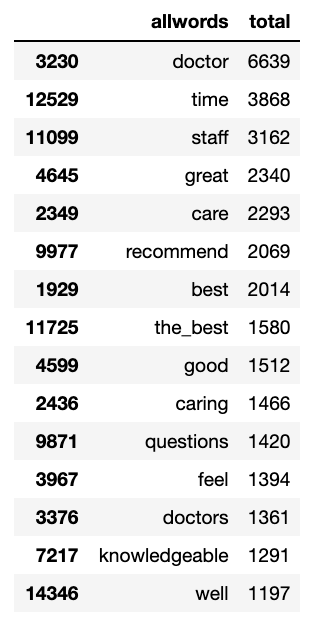

#### Most frequent phrases

In [41]:
freq['under_count'] = freq.allwords.str.count('_')
freq[freq.under_count>=3][['allwords','total']].head(15)

allwords  total
5344              he_is_the_best    157
6835          is_the_best_doctor    139
12154         the_time_to_listen    126
12607          time_to_listen_to    122
3545             easy_to_talk_to    109
11736       the_best_doctor_have     96
4899          has_been_my_doctor     96
1808          been_my_doctor_for     95
6903   is_very_knowledgeable_and     94
10724            she_the_time_to     93
4900      has_been_my_doctor_for     86
10613            she_is_the_best     85
5476              he_the_time_to     84
6762              is_of_the_best     82
12152        the_time_to_explain     79

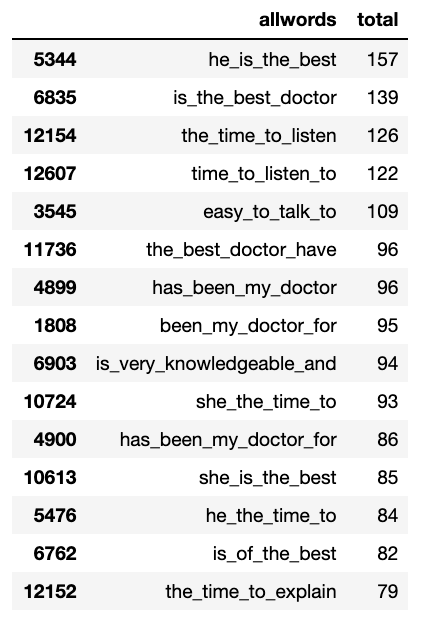

#### Calculate Fisher's Discriminant Score

In [42]:
mask = pd.DataFrame(random_sub.is_good)
good_df = dtm.iloc[np.any(mask.values,axis=1),]
bad_df = dtm.iloc[~np.any(mask.values,axis=1),]

# Make sure the good and bad reviews add up to 1
(len(bad_df) + len(good_df))/len(dtm)

1.0

In [43]:
FiDi = pd.DataFrame(((good_df.mean() - bad_df.mean())**2)/(np.std(good_df)**2 + np.std(bad_df)**2)).reset_index().rename(columns = {"level_0":"term", 0:"FiDi_score"})
words = FiDi.term.tolist()
words = stopText(words)
words = stopOther(words)
words = pd.Series(words).str.lstrip(" ").tolist()
FiDi = FiDi[FiDi.term.isin(words)].sort_values(by = 'FiDi_score', ascending = False)
FiDi.head(15)
#FiDi['under_count'] = FiDi.term.str.count('_')
#FiDi[FiDi.under_count>=3][['term','FiDi_score']].head(15)

term  FiDi_score
10273              rude    0.168703
1929               best    0.128213
11725          the_best    0.123097
4645              great    0.120263
2436             caring    0.094559
5811             highly    0.094136
3726          excellent    0.093493
14849             worst    0.087540
12374       this_doctor    0.077500
5819   highly_recommend    0.076407
14800         wonderful    0.076245
7217      knowledgeable    0.075193
6067           horrible    0.069241
10274          rude_and    0.068196
13518    unprofessional    0.065511

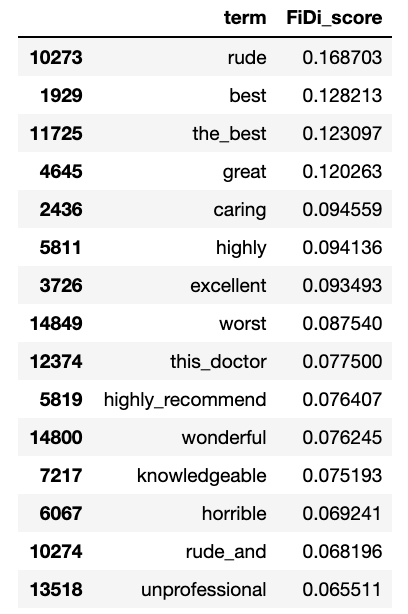

## Word Embedding for Good and Bad Reviews

We use word embedding on popular but general terms to find out related words that help define why patients were either pleased or displeased. 

#### Good Reviews

In [44]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Tokenize each document
def textTokenize(text_array):
   textTokens = []
   for h in text_array:
       textTokens.append(h.split(' '))
   return textTokens


sentences_g = textTokenize(reviews_good)
while("" in sentences_g) : 
   sentences_g.remove("")

#Train the model on Word2Vec
model_g = gensim.models.Word2Vec(sentences_g, min_count=1)

df_words_good = pd.DataFrame()
word_list_good = ('time', 'call', 'staff', 'great', 'visit', 'well', 'good', 'care', 'doctors')
for i in word_list_good: 
  output = model_g.wv.most_similar(i,topn=7)
  dic = {i: output}
  df = pd.DataFrame.from_dict(dic).T
  df_words_good = pd.concat([df, df_words_good], sort=True)
df_words_good = df_words_good.rename(columns = {0: "word_1", 1: "word_2", 2: "word_3", 3: "word_4", 4: "word_5", 5: "word_6", 6: "word_7"})  

# Make an output dataframe without tuples
for col in df_words_good.columns:
  df_words_good[col] = df_words_good[col].apply(lambda x: x[0])
  
df_words_good

word_1        word_2      word_3         word_4        word_5  \
doctors   patience     wellbeing      parent          helps       matters   
care       surgeon         field       human  diagnostician        jafari   
good         great    impeccable  kamenetsky       terrific         funny   
well       enjoyed  approachable      person       provides       genuine   
visit      welcome      welcomed      secure        relaxed     confident   
great         good     excellent   wonderful       terrific    kamenetsky   
staff    courteous     efficient      polite          super  professional   
call       annoyed          test       right         length       results   
time           sit         spent        rush           talk       explain   

                word_6       word_7  
doctors        parents      towards  
care             bonus       treats  
good     nonjudgmental  personality  
well            direct        knows  
visit        important       imtiaz  
great            humor  personality  
staff         friendly         nice  
call              hour      awkward  
time            listen       spends

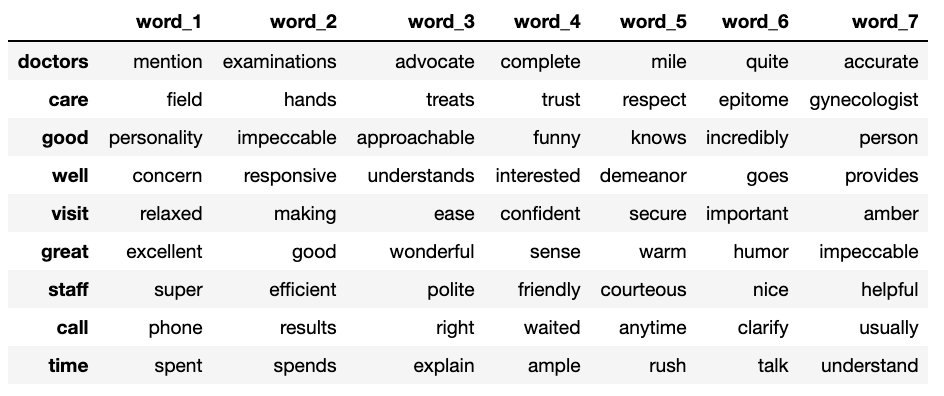

### Bad Reviews

In [45]:
sentences_b = textTokenize(reviews_bad)
while("" in sentences_b) : 
   sentences_b.remove("")

# Cleaning out the space 
sentences_b_new = []
for c in sentences_b:
  sentences_b_new.append([e for e in c if e not in ("")])


#Train the model on Word2Vec
model_b = gensim.models.Word2Vec(sentences_b_new, min_count=1)

df_words_bad = pd.DataFrame()
word_list_bad = ('time', 'highly', 'staff', 'appointment', 'worst', 'wonderful', 'asked', 'called', 'recommend', 'surgery', 'doctors')
for i in word_list_bad: 
  output = model_b.wv.most_similar(i,topn=7)
  dic = {i: output}
  df = pd.DataFrame.from_dict(dic).T
  df_words_bad = pd.concat([df, df_words_bad], sort=True)
df_words_bad = df_words_bad.rename(columns = {0: "word_1", 1: "word_2", 2: "word_3", 3: "word_4", 4: "word_5", 5: "word_6", 6: "word_7"})  

# Make an output dataframe without tuples
for col in df_words_bad.columns:
  df_words_bad[col] = df_words_bad[col].apply(lambda x: x[0])
  
df_words_bad

word_1          word_2         word_3         word_4  \
doctors       physician           obgyn          worse       practice   
surgery      medication          cancer      infection     specialist   
recommend         awful            lack    encountered     compassion   
called             call            week           appt           next   
asked              come             set          month          nurse   
wonderful         avoid          better         please          human   
worst          horrible            poor     experience       terrible   
appointment        time           hours          lobby           mins   
staff         extremely  unprofessional  disrespectful  inconsiderate   
highly           better           avoid          trust           seem   
time              lobby            long           mins           half   

                    word_5       word_6    word_7  
doctors               life        trust      deal  
surgery              found    diagnosis       due  
recommend    condescending          bad    skills  
called             finally        still     times  
asked               showed      morning     weeks  
wonderful        competent        trust    highly  
worst                enemy        awful       bed  
appointment           long         half    packed  
staff             uncaring         rude  customer  
highly               cares       please  practice  
time                  late  appointment      exam

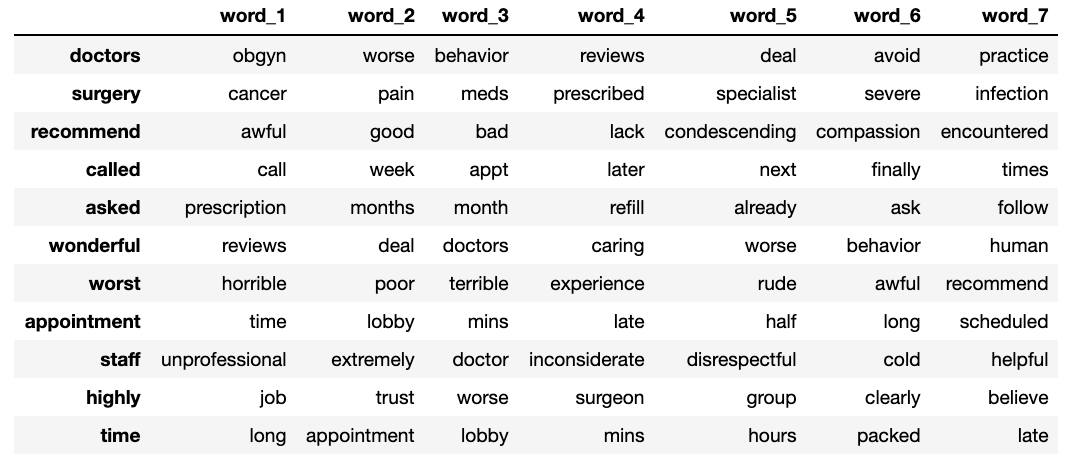

## Topic Analysis Using LDA

1. Find Top Six Topics
2. Find Top Seven Words within each Topic
3. Repeat for all, good, and bad reviews

#### Topic Analysis for Overall Reviews

In [46]:
# Topic Analysis for all reviews
rvws_all = stopText(reviews_all)
rvws_all = removePunc(rvws_all)
rvws_all = stopOther(rvws_all)
rvws_all =lemmText(rvws_all)
clean_rvws_all = [i.split() for i in rvws_all]

# Cleaning out the apostrophe 
clean_rvws_all_new = []
for c in clean_rvws_all:
  clean_rvws_all_new.append([e for e in c if e not in ("’")])

# Creating the term dictionary of our reviews, where every unique term is assigned an index. 
dictionary_all = corpora.Dictionary(clean_rvws_all_new)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_all = [dictionary_all.doc2bow(doc) for doc in clean_rvws_all_new]

In [47]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel_all = Lda(doc_term_matrix_all, num_topics=6, id2word = dictionary_all, passes=50)

#Results
#print(ldamodel_all.print_topics(num_topics=6, num_words=7))

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'care'),
 Text(0, 0, 'doctor'),
 Text(0, 0, 'recommend'),
 Text(0, 0, 'best'),
 Text(0, 0, 'great'),
 Text(0, 0, 'highly'),
 Text(0, 0, 'staff'),
 Text(0, 0, 'manner'),
 Text(0, 0, 'excellent'),
 Text(0, 0, 'knowledgeable')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'surgery'),
 Text(0, 0, 'life'),
 Text(0, 0, 'surgeon'),
 Text(0, 0, 'hospital'),
 Text(0, 0, 'save'),
 Text(0, 0, 'delivery'),
 Text(0, 0, 'thank'),
 Text(0, 0, 'perform'),
 Text(0, 0, 'procedure'),
 Text(0, 0, 'ob')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'time'),
 Text(0, 0, 'doctor'),
 Text(0, 0, 'question'),
 Text(0, 0, 'staff'),
 Text(0, 0, 'answer'),
 Text(0, 0, 'great'),
 Text(0, 0, 'care'),
 Text(0, 0, 'listen'),
 Text(0, 0, 'feel'),
 Text(0, 0, 'good')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'supportive'),
 Text(0, 0, 'perfect'),
 Text(0, 0, 'twin'),
 Text(0, 0, 'empathetic'),
 Text(0, 0, 'outcome'),
 Text(0, 0, 'que'),
 Text(0, 0, 'miles'),
 Text(0, 0, 'davis'),
 Text(0, 0, 'el'),
 Text(0, 0, 'drive')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'doctor'),
 Text(0, 0, 'test'),
 Text(0, 0, 'give'),
 Text(0, 0, 'know'),
 Text(0, 0, 'result'),
 Text(0, 0, 'find'),
 Text(0, 0, 'care'),
 Text(0, 0, 'take'),
 Text(0, 0, 'insurance'),
 Text(0, 0, 'time')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'call'),
 Text(0, 0, 'wait'),
 Text(0, 0, 'doctor'),
 Text(0, 0, 'time'),
 Text(0, 0, 'baby'),
 Text(0, 0, 'appointment'),
 Text(0, 0, 'staff'),
 Text(0, 0, 'room'),
 Text(0, 0, 'ask'),
 Text(0, 0, 'nurse')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

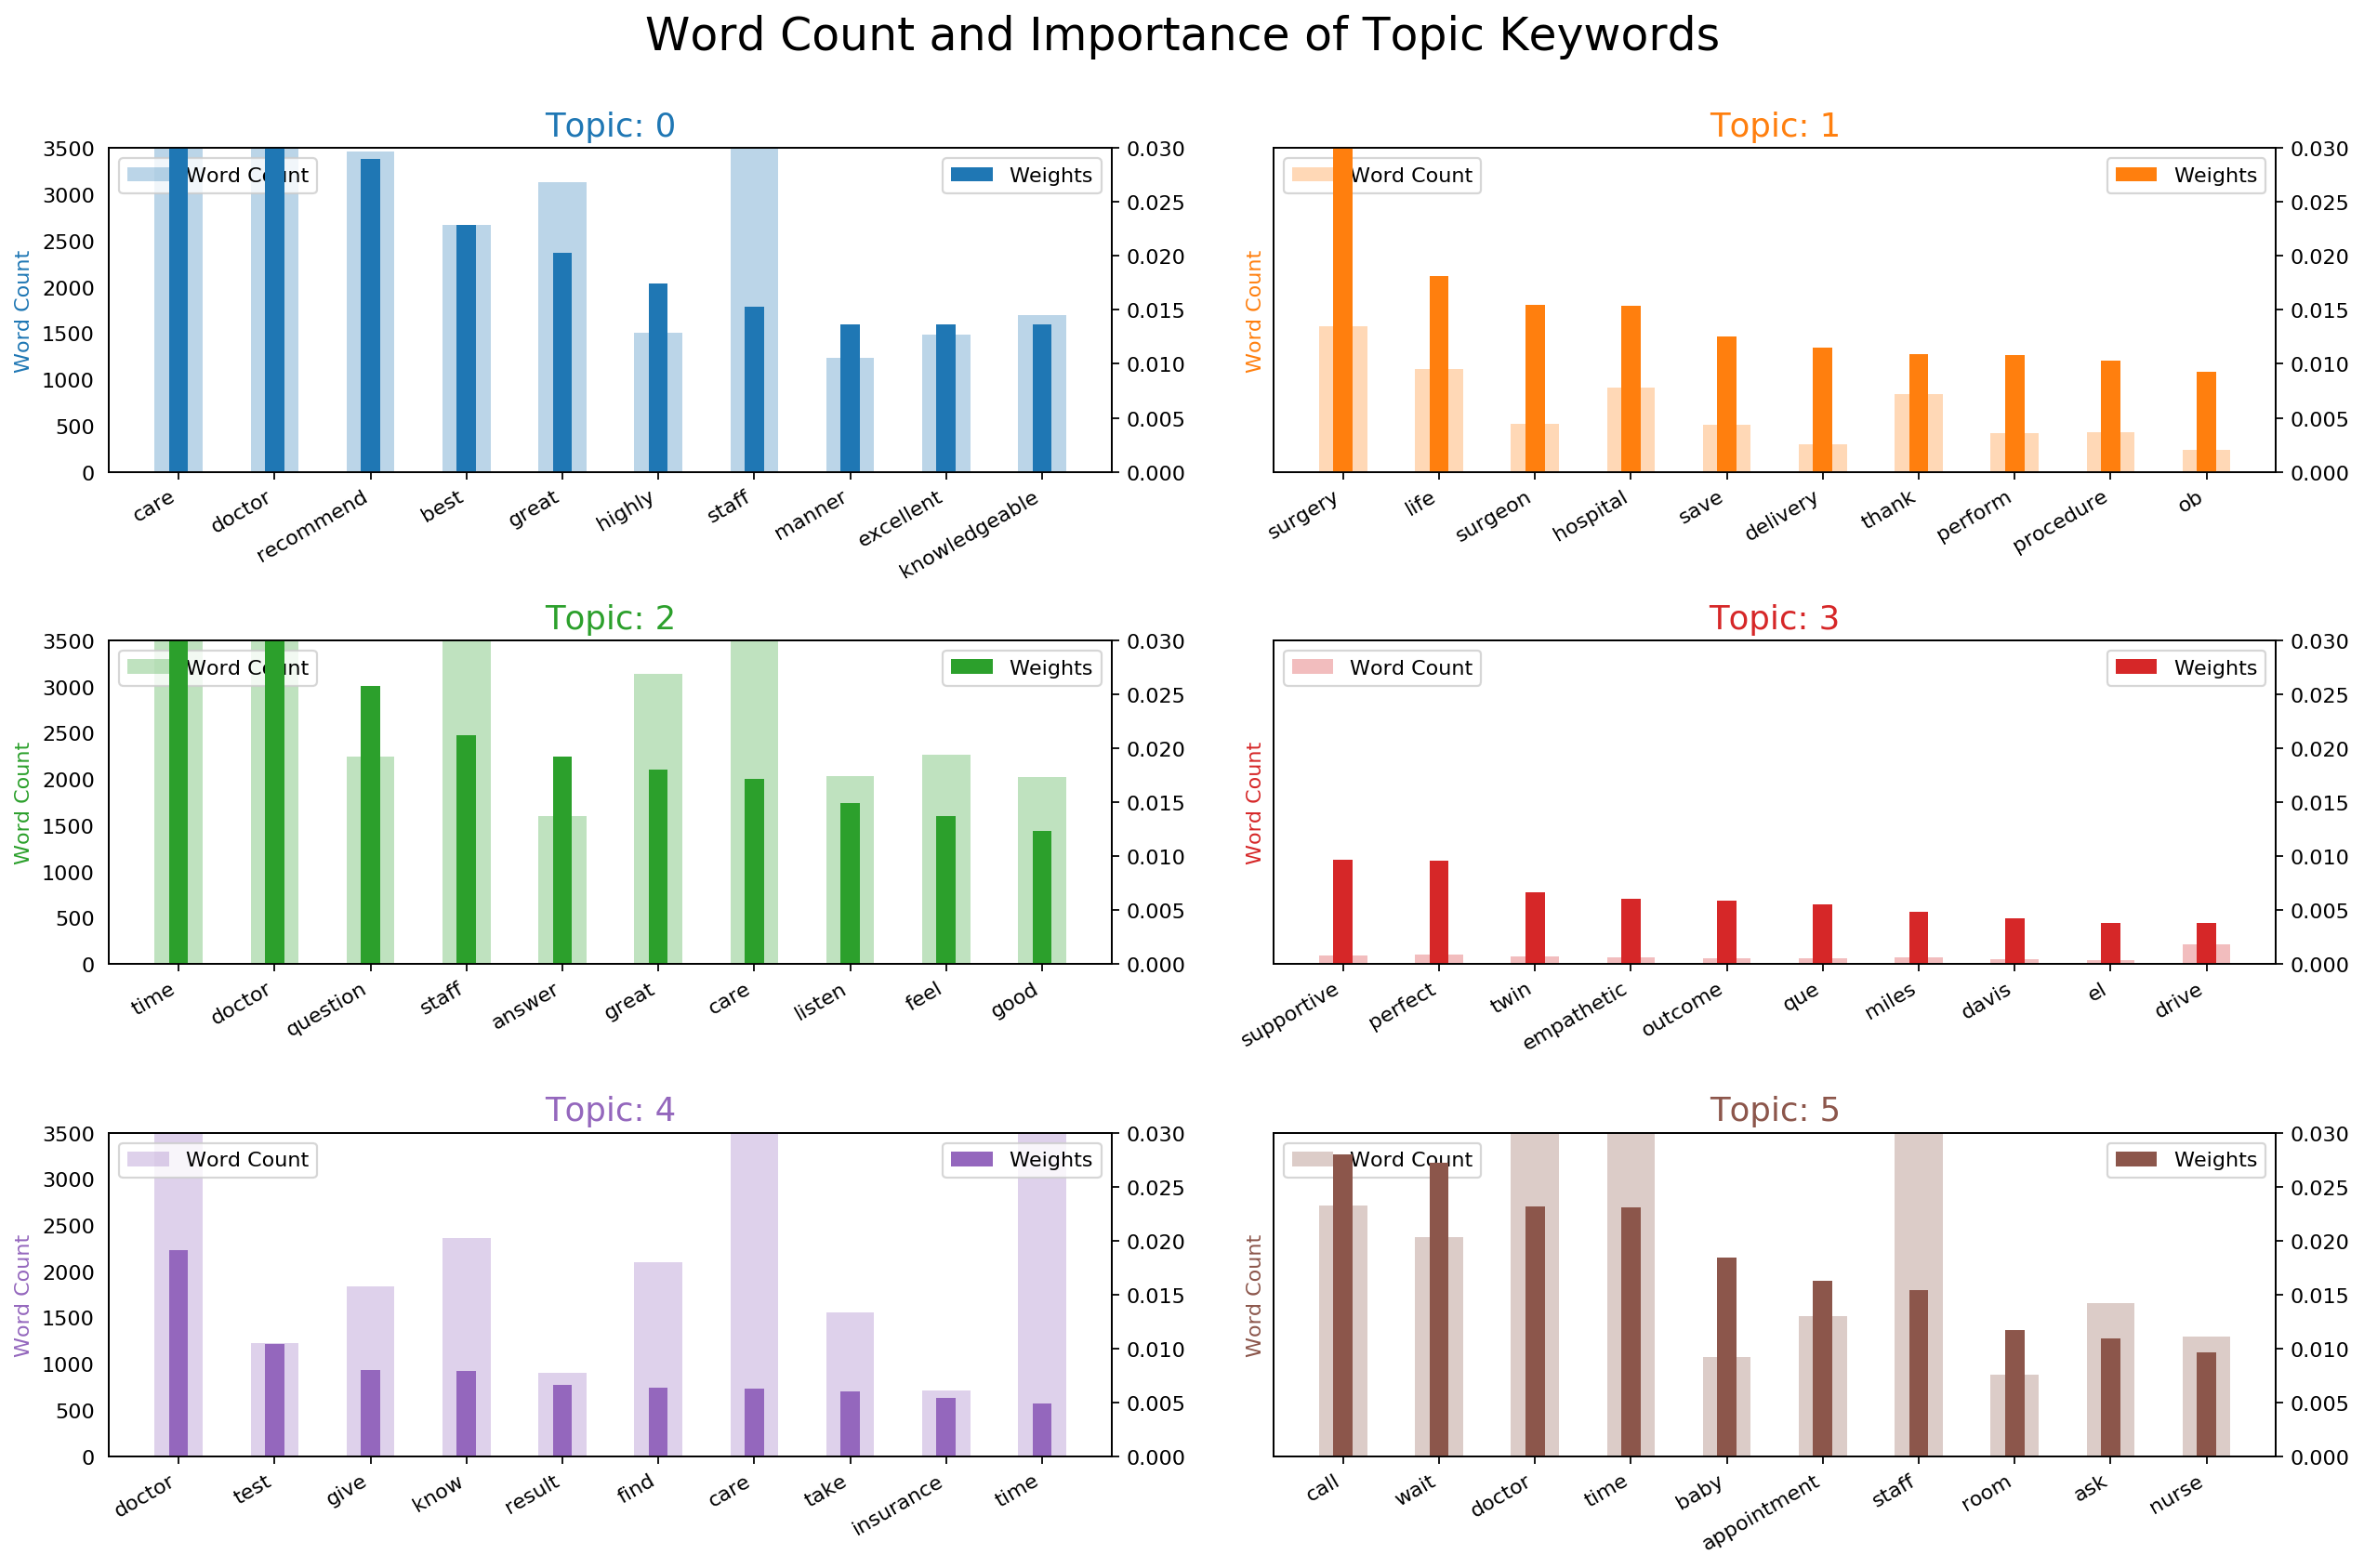

In [48]:
topics = ldamodel_all.show_topics(formatted=False)
data_flat = [w for w_list in clean_rvws_all_new for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
   for word, weight in topic:
       out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = pyplot.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
   ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
   ax_twin = ax.twinx()
   ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
   ax.set_ylabel('Word Count', color=cols[i])
   ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
   ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
   ax.tick_params(axis='y', left=False)
   ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
   ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
pyplot.show()


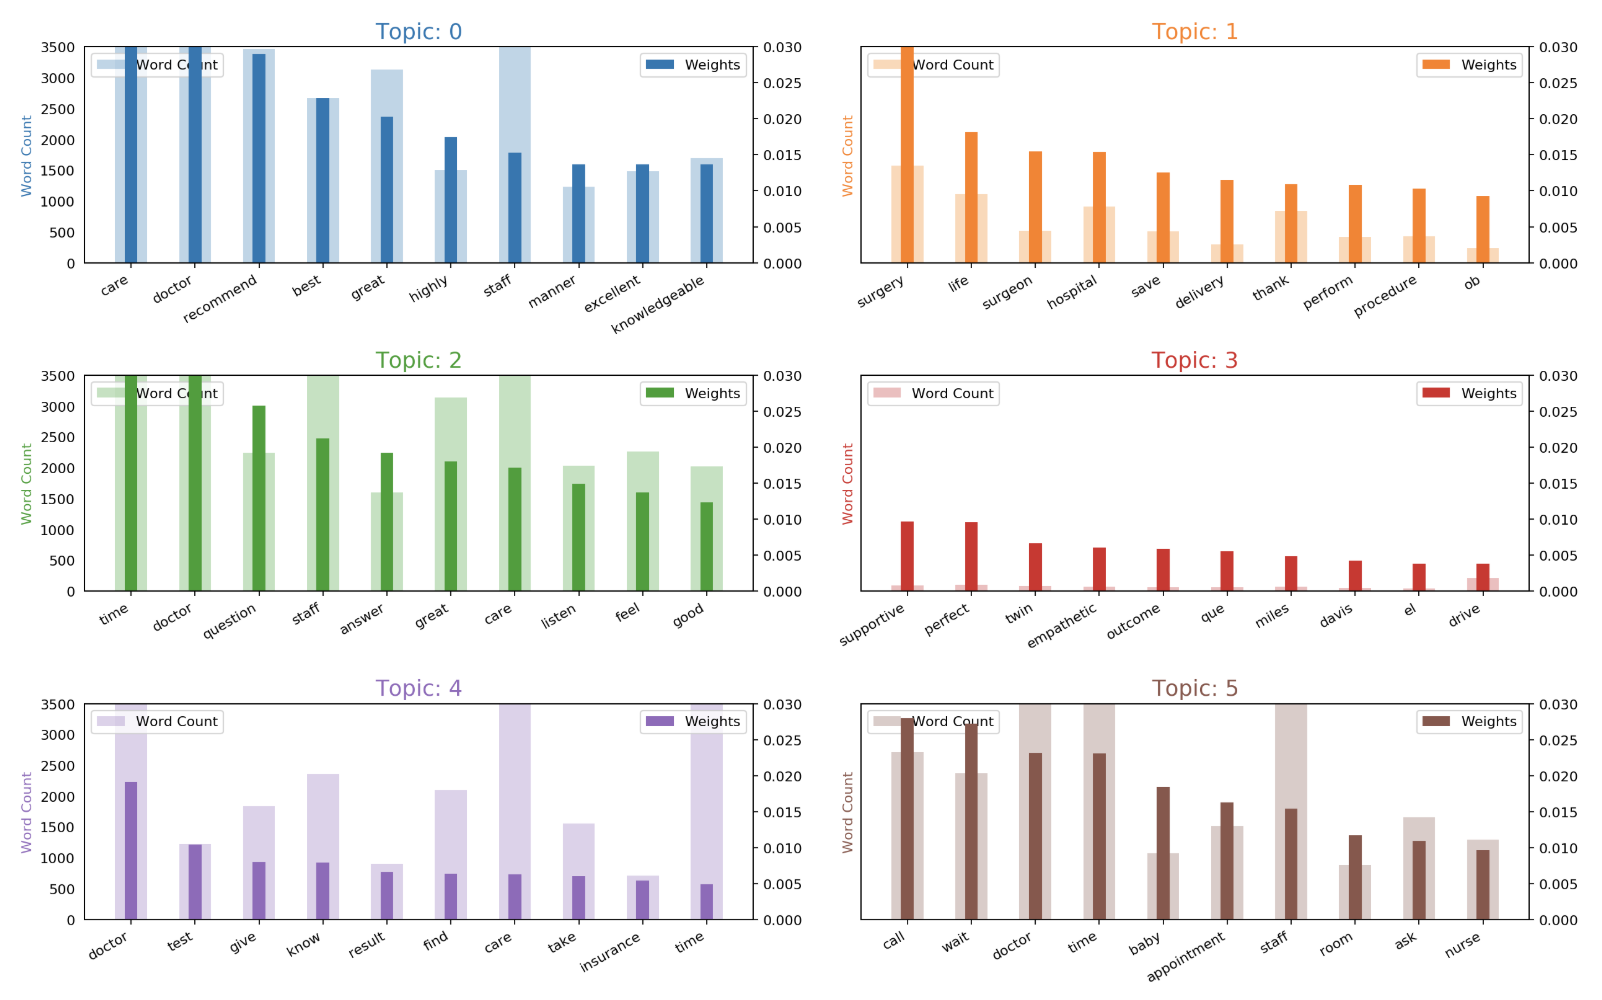

In [61]:
pyLDAvis.enable_notebook()
vis_all = pyLDAvis.gensim.prepare(ldamodel_all, doc_term_matrix_all, dictionary=ldamodel_all.id2word)

In [63]:
vis_all

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.085576 -0.084803       1        1  27.323574
0     -0.154639  0.129256       2        1  20.880772
2     -0.174255  0.087944       3        1  20.573895
5     -0.100516 -0.071762       4        1  19.398972
1      0.165540 -0.228549       5        1   8.872051
3      0.349447  0.167913       6        1   2.950740, topic_info=      Category         Freq             Term        Total  loglift  logprob
489    Default  1618.000000          surgery  1618.000000  30.0000  30.0000
23     Default  5436.000000             care  5436.000000  29.0000  29.0000
48     Default  2455.000000             call  2455.000000  28.0000  28.0000
595    Default  2231.000000             wait  2231.000000  27.0000  27.0000
210    Default  2308.000000         question  2308.000000  26.0000  26.0000
8      Default  2954.000000            great  2954.000000  25.0000  25.0000
113    Default  5530.000000             time  5530.000000  24.0000  24.0000
4756   Default  1331.000000             baby  1331.000000  23.0000  23.0000
172    Default  1360.000000           highly  1360.000000  22.0000  22.0000
21     Default  2466.000000             best  2466.000000  21.0000  21.0000
203    Default  1629.000000           answer  1629.000000  20.0000  20.0000
177    Default  3287.000000        recommend  3287.000000  19.0000  19.0000
47     Default  1430.000000      appointment  1430.000000  18.0000  18.0000
3      Default  1041.000000          bedside  1041.000000  17.0000  17.0000
109    Default  4098.000000            staff  4098.000000  16.0000  16.0000
50     Default   993.000000             life   993.000000  15.0000  15.0000
142    Default  1112.000000           manner  1112.000000  14.0000  14.0000
151    Default  1476.000000    knowledgeable  1476.000000  13.0000  13.0000
87     Default  1298.000000        excellent  1298.000000  12.0000  12.0000
948    Default   842.000000             room   842.000000  11.0000  11.0000
723    Default   910.000000         hospital   910.000000  10.0000  10.0000
35     Default  1498.000000             love  1498.000000   9.0000   9.0000
365    Default  1785.000000           listen  1785.000000   8.0000   8.0000
661    Default   510.000000          surgeon   510.000000   7.0000   7.0000
85     Default  1227.000000        wonderful  1227.000000   6.0000   6.0000
423    Default  1110.000000             test  1110.000000   5.0000   5.0000
5919   Default  1225.000000          deliver  1225.000000   4.0000   4.0000
280    Default  1187.000000     professional  1187.000000   3.0000   3.0000
148    Default  2268.000000             feel  2268.000000   2.0000   2.0000
708    Default   628.000000          minutes   628.000000   1.0000   1.0000
1156    Topic1   292.389130         symptoms   293.181244   1.2947  -5.8525
842     Topic1   265.694885        prescribe   266.485321   1.2944  -5.9482
468     Topic1   263.204376            order   263.997650   1.2944  -5.9576
1073    Topic1   236.124847       medication   236.916763   1.2941  -6.0662
835     Topic1   178.349655             meds   179.141663   1.2930  -6.3468
331     Topic1   175.926056          company   176.717575   1.2929  -6.3605
1289    Topic1   156.749176           weight   157.540939   1.2924  -6.4759
1057    Topic1   157.210709            cover   158.004913   1.2924  -6.4730
1194    Topic1   153.921783         pressure   154.714737   1.2923  -6.4941
818     Topic1   152.884796         arrogant   153.676666   1.2923  -6.5009
2313    Topic1   132.202087          mistake   132.995590   1.2914  -6.6462
1603    Topic1   132.189636              cry   132.985413   1.2914  -6.6463
845     Topic1   125.311150           report   126.104225   1.2911  -6.6998
1293    Topic1   121.957130             cost   122.751060   1.2909  -6.7269
385     Topic1   120.066200          require   120.860886   1.2908  -6.7425
890     Topic1   118.612595  

## Topic Analysis for Good Reviews

In [51]:
# Topic Analysis for good reviews
rvws_g = stopText(reviews_good)
rvws_g = removePunc(rvws_g)
rvws_g = stopOther(rvws_g)
rvws_g =lemmText(rvws_g)
clean_rvws_g = [i.split() for i in rvws_g]

# Cleaning out the apostrophe 
clean_rvws_g_new = []
for c in clean_rvws_g:
  clean_rvws_g_new.append([e for e in c if e not in ("’")])

# Creating the term dictionary of our reviews, where every unique term is assigned an index. 
dictionary_g = corpora.Dictionary(clean_rvws_g_new)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_g = [dictionary_g.doc2bow(doc) for doc in clean_rvws_g_new]

In [52]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix for good reviews
ldamodel_g = Lda(doc_term_matrix_g, num_topics=6, id2word = dictionary_g, passes=50)

#Results
#print(ldamodel_g.print_topics(num_topics=6, num_words=7))

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'care'),
 Text(0, 0, 'doctor'),
 Text(0, 0, 'recommend'),
 Text(0, 0, 'staff'),
 Text(0, 0, 'great'),
 Text(0, 0, 'time'),
 Text(0, 0, 'professional'),
 Text(0, 0, 'highly'),
 Text(0, 0, 'knowledgeable'),
 Text(0, 0, 'feel')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'daughter'),
 Text(0, 0, 'process'),
 Text(0, 0, 'become'),
 Text(0, 0, 'twin'),
 Text(0, 0, 'well'),
 Text(0, 0, 'boys'),
 Text(0, 0, 'zach'),
 Text(0, 0, 'start'),
 Text(0, 0, 'ultrasound'),
 Text(0, 0, 'like')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'life'),
 Text(0, 0, 'save'),
 Text(0, 0, 'best'),
 Text(0, 0, 'god'),
 Text(0, 0, 'baby'),
 Text(0, 0, 'thank'),
 Text(0, 0, 'mother'),
 Text(0, 0, 'bless'),
 Text(0, 0, 'birth'),
 Text(0, 0, 'surgeon')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'doctor'),
 Text(0, 0, 'time'),
 Text(0, 0, 'care'),
 Text(0, 0, 'know'),
 Text(0, 0, 'great'),
 Text(0, 0, 'love'),
 Text(0, 0, 'best'),
 Text(0, 0, 'wait'),
 Text(0, 0, 'good'),
 Text(0, 0, 'question')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'care'),
 Text(0, 0, 'deliver'),
 Text(0, 0, 'doctor'),
 Text(0, 0, 'give'),
 Text(0, 0, 'baby'),
 Text(0, 0, 'life'),
 Text(0, 0, 'help'),
 Text(0, 0, 'treatment'),
 Text(0, 0, 'health'),
 Text(0, 0, 'issue')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'surgery'),
 Text(0, 0, 'call'),
 Text(0, 0, 'staff'),
 Text(0, 0, 'hospital'),
 Text(0, 0, 'procedure'),
 Text(0, 0, 'result'),
 Text(0, 0, 'surgeon'),
 Text(0, 0, 'find'),
 Text(0, 0, 'perform'),
 Text(0, 0, 'ob')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

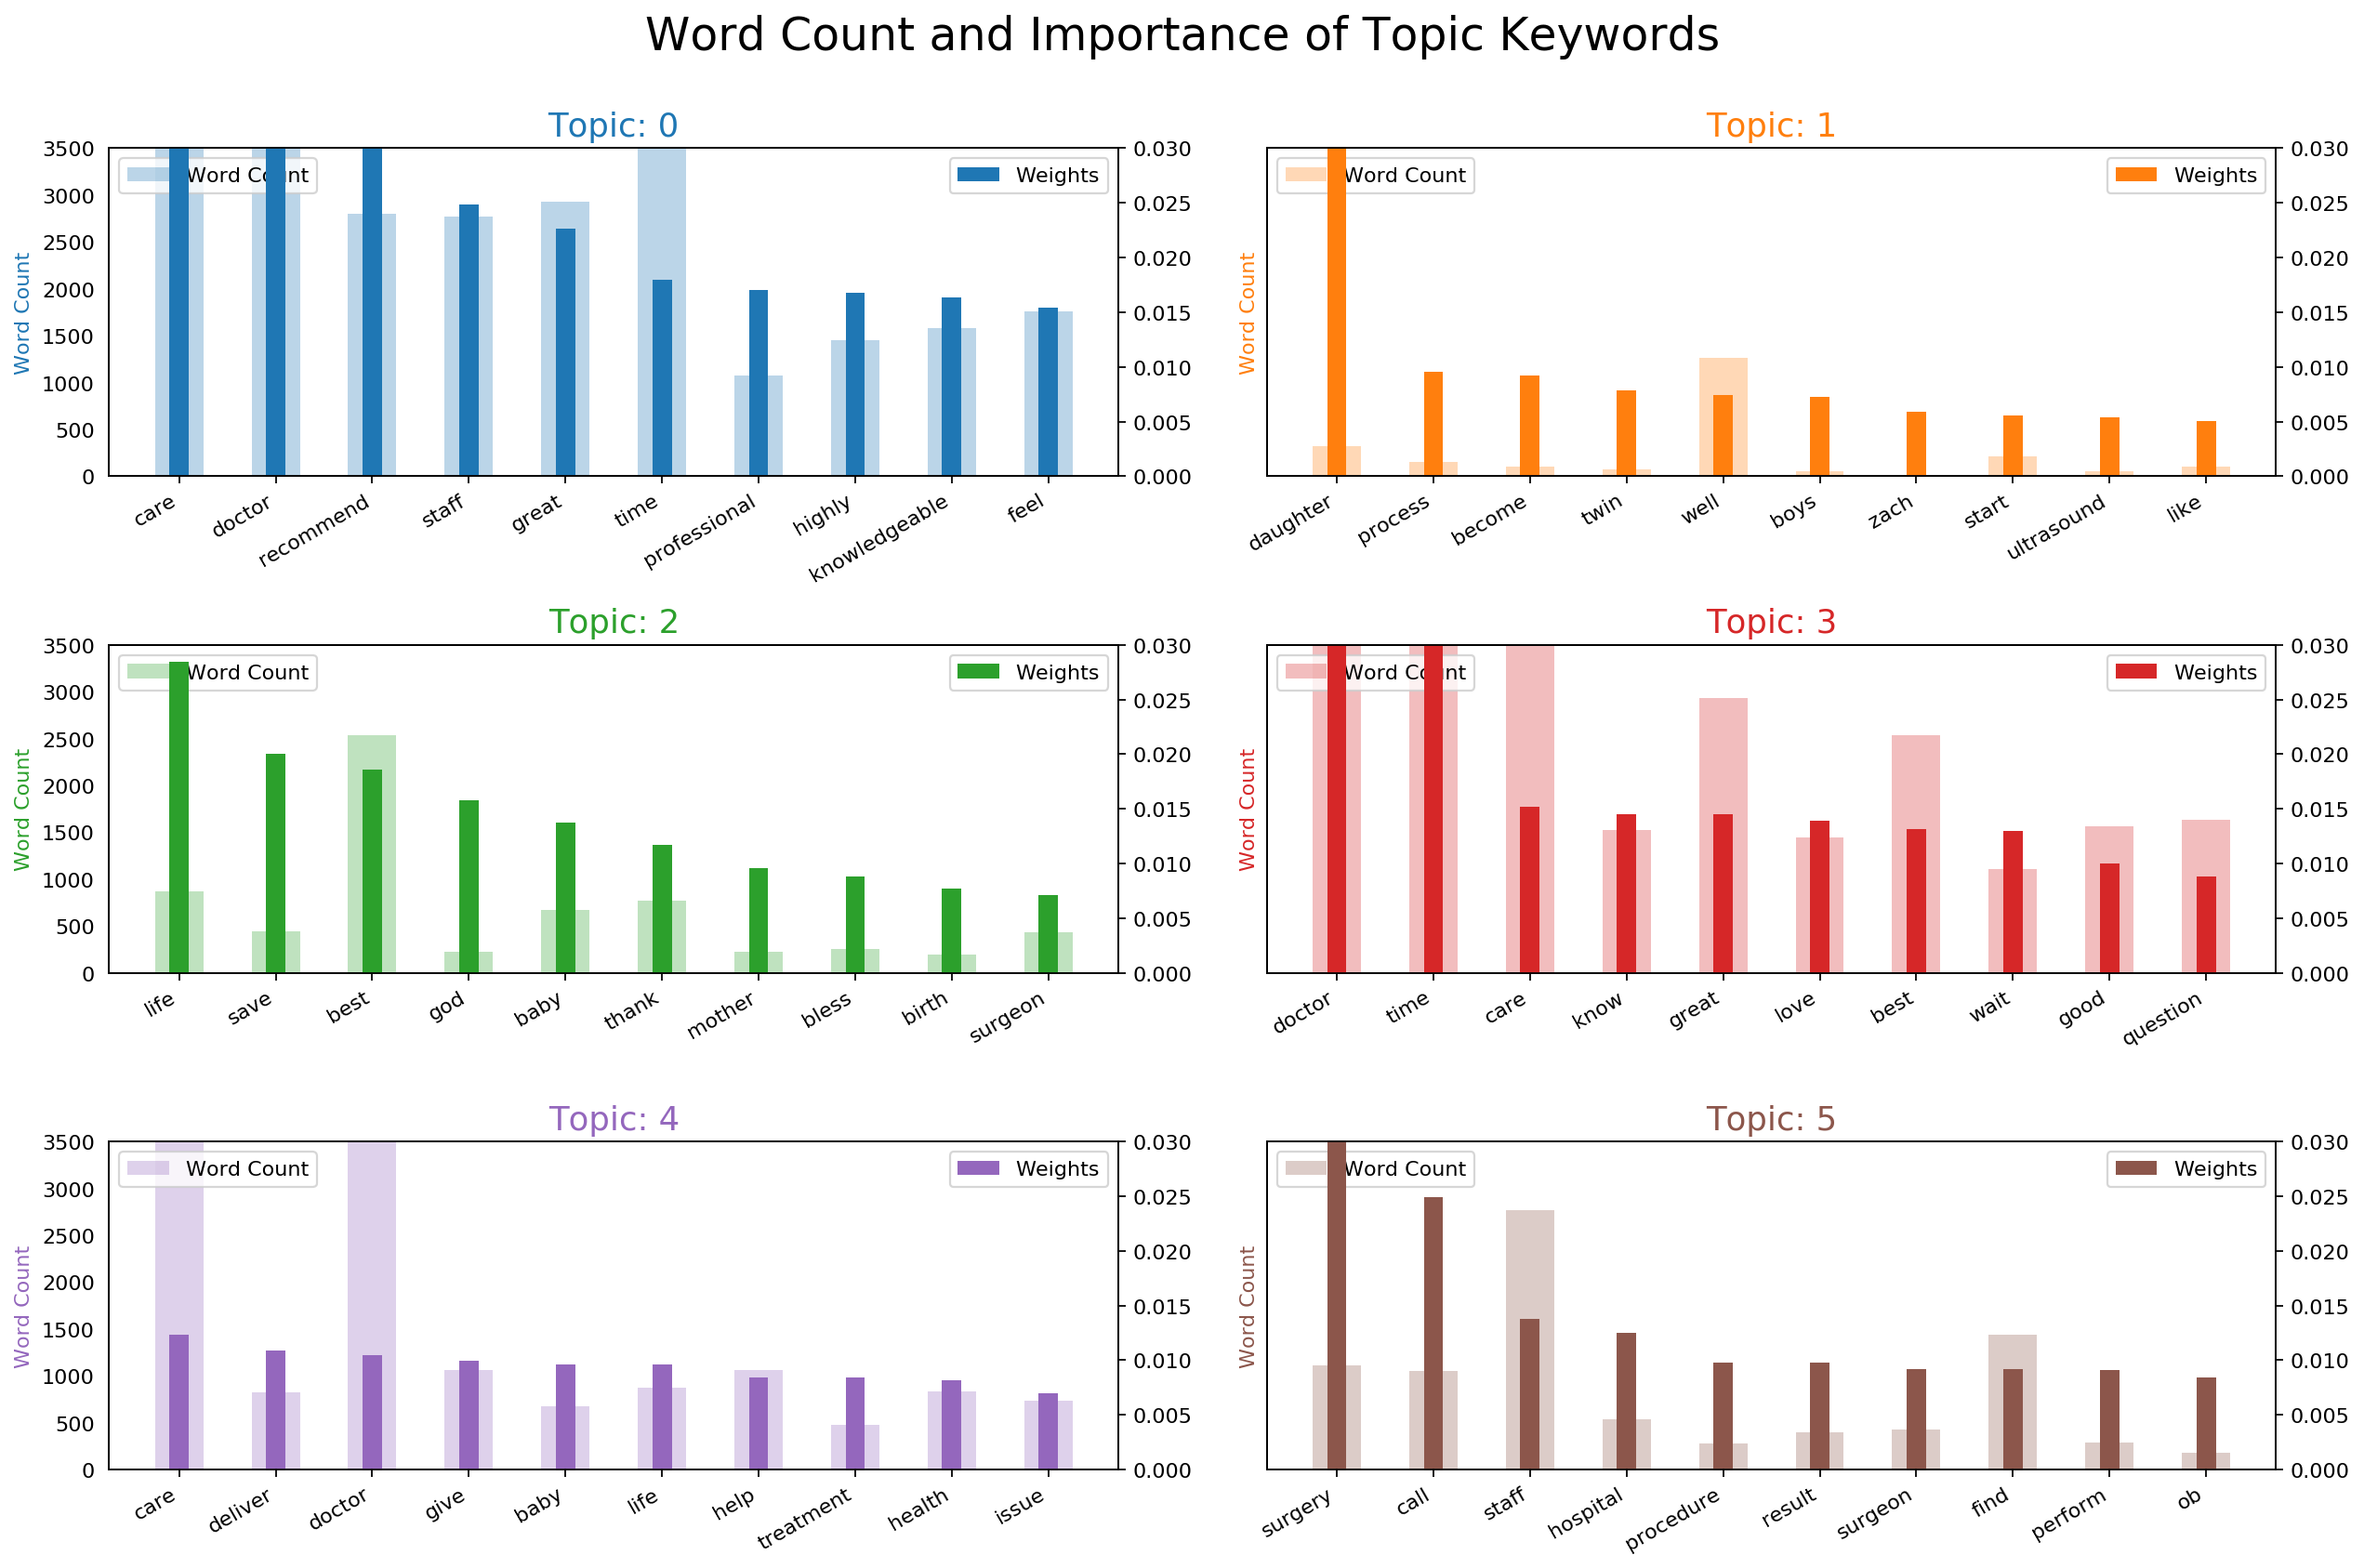

In [53]:
topics = ldamodel_g.show_topics(formatted=False)
data_flat = [w for w_list in clean_rvws_g_new for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
   for word, weight in topic:
       out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = pyplot.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
   ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
   ax_twin = ax.twinx()
   ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
   ax.set_ylabel('Word Count', color=cols[i])
   ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
   ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
   ax.tick_params(axis='y', left=False)
   ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
   ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
pyplot.show()


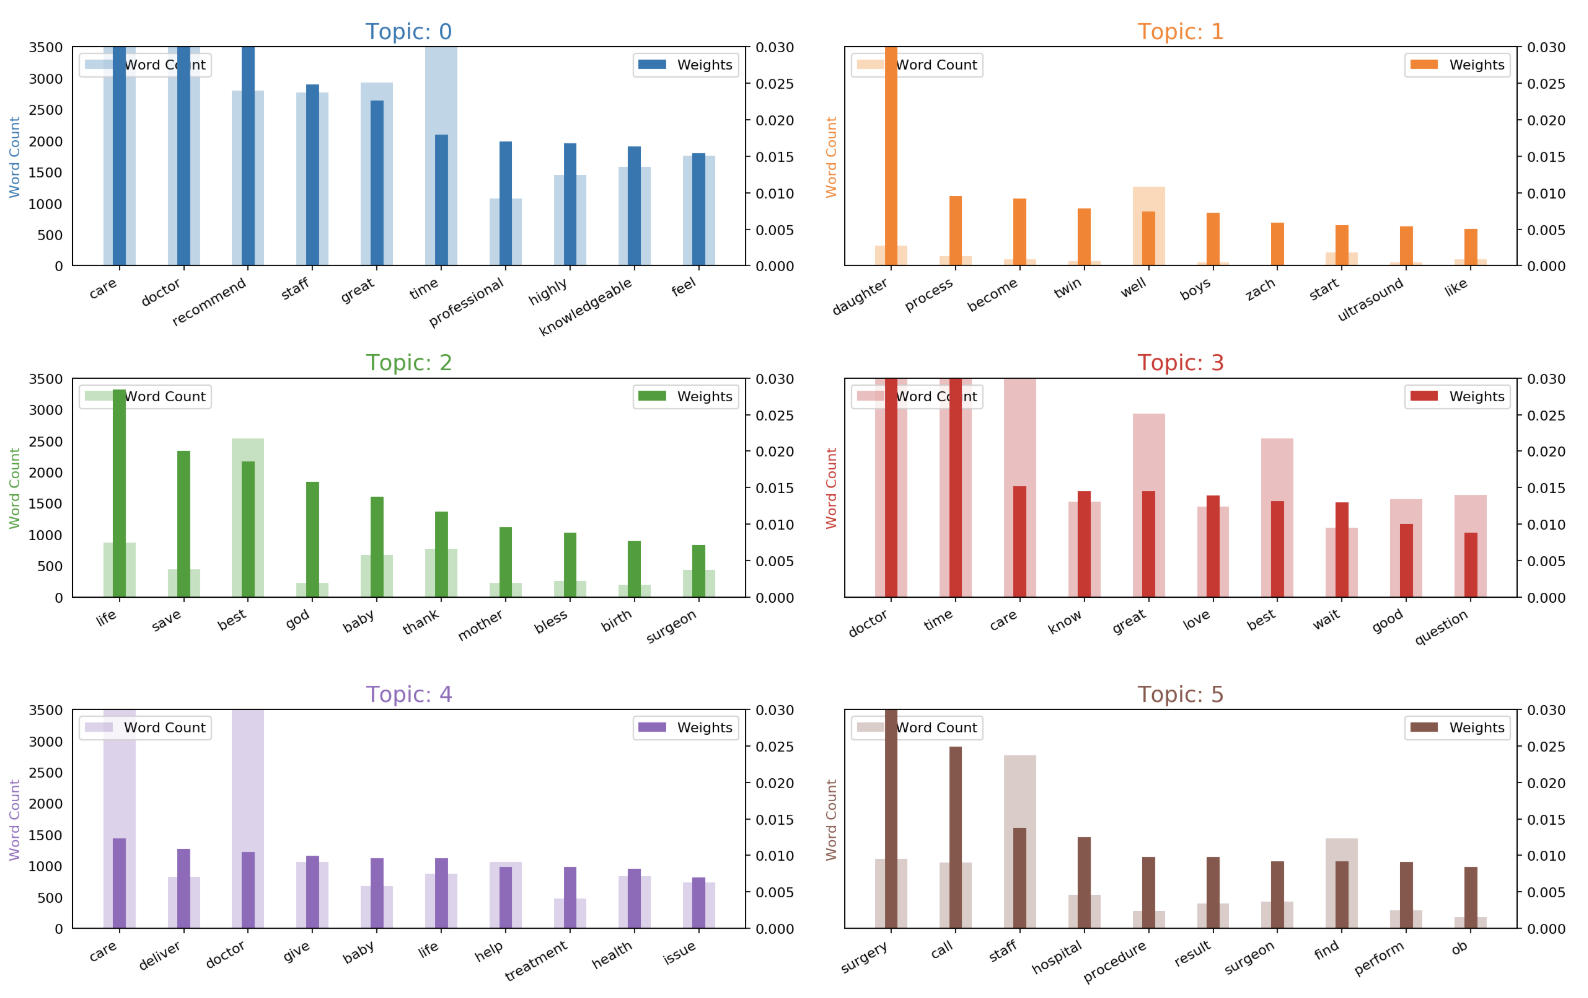

In [62]:
pyLDAvis.enable_notebook()
vis_g = pyLDAvis.gensim.prepare(ldamodel_g, doc_term_matrix_g, dictionary=ldamodel_g.id2word)

In [64]:
vis_g

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.218043 -0.029996       1        1  32.872364
0     -0.251295 -0.089474       2        1  27.107216
4     -0.068365  0.029581       3        1  20.742418
5      0.064956  0.269890       4        1  11.024749
2      0.218723 -0.033730       5        1   4.396763
1      0.254024 -0.146269       6        1   3.856496, topic_info=      Category         Freq             Term        Total  loglift  logprob
404    Default  1095.000000          surgery  1095.000000  30.0000  30.0000
26     Default  6305.000000           doctor  6305.000000  29.0000  29.0000
23     Default  4484.000000             care  4484.000000  28.0000  28.0000
177    Default  2476.000000        recommend  2476.000000  27.0000  27.0000
50     Default   753.000000             life   753.000000  26.0000  26.0000
21     Default  2271.000000             best  2271.000000  25.0000  25.0000
48     Default   926.000000             call   926.000000  24.0000  24.0000
280    Default  1096.000000     professional  1096.000000  23.0000  23.0000
109    Default  2606.000000            staff  2606.000000  22.0000  22.0000
172    Default  1128.000000           highly  1128.000000  21.0000  21.0000
113    Default  3701.000000             time  3701.000000  20.0000  20.0000
3510   Default   788.000000             baby   788.000000  19.0000  19.0000
515    Default   990.000000             wait   990.000000  18.0000  18.0000
8      Default  2689.000000            great  2689.000000  17.0000  17.0000
781    Default   340.000000         daughter   340.000000  16.0000  16.0000
151    Default  1383.000000    knowledgeable  1383.000000  15.0000  15.0000
305    Default   346.000000             save   346.000000  14.0000  14.0000
210    Default  1567.000000         question  1567.000000  13.0000  13.0000
112    Default   740.000000            thank   740.000000  12.0000  12.0000
4311   Default  1032.000000          deliver  1032.000000  11.0000  11.0000
296    Default   881.000000         friendly   881.000000  10.0000  10.0000
268    Default   871.000000          helpful   871.000000   9.0000   9.0000
73     Default   281.000000              god   281.000000   8.0000   8.0000
325    Default  1288.000000          concern  1288.000000   7.0000   7.0000
627    Default   523.000000         hospital   523.000000   6.0000   6.0000
552    Default   405.000000        treatment   405.000000   5.0000   5.0000
567    Default   380.000000          surgeon   380.000000   4.0000   4.0000
87     Default  1239.000000        excellent  1239.000000   3.0000   3.0000
203    Default  1136.000000           answer  1136.000000   2.0000   2.0000
35     Default  1660.000000             love  1660.000000   1.0000   1.0000
515     Topic1   989.906372             wait   990.738098   1.1117  -4.3461
34      Topic1   461.463867             long   462.296417   1.1107  -5.1093
1646    Topic1   375.959961              kid   376.793762   1.1103  -5.3143
907     Topic1   170.522629             seem   171.355667   1.1077  -6.1049
349     Topic1   167.791275        sometimes   168.622925   1.1076  -6.1210
832     Topic1   155.539001            thing   156.372330   1.1072  -6.1968
758     Topic1   149.235916             hour   150.068604   1.1070  -6.2382
916     Topic1   125.119987          wouldnt   125.952942   1.1059  -6.4145
747     Topic1   118.770950            stuff   119.603020   1.1056  -6.4665
1406    Topic1   118.716072            thats   119.547844   1.1056  -6.4670
3124    Topic1    98.959320              gyn    99.796677   1.1041  -6.6490
424     Topic1    97.668526          usually    98.500809   1.1041  -6.6622
568     Topic1    83.613640            worry    84.447739   1.1026  -6.8175
4075    Topic1    81.836876           breast    82.682350   1.1023  -6.8390
57      Topic1    73.019333         anywhere    73.850266   1.1012  -6.9530
7125    Topic1    72.329994  

## Topic Analysis for Bad Reviews

In [56]:
# Topic Analysis for good reviews
rvws_b = stopText(reviews_bad)
rvws_b = removePunc(rvws_b)
rvws_b = stopOther(rvws_b)
rvws_b =lemmText(rvws_b)
clean_rvws_b = [i.split() for i in rvws_b]

# Cleaning out the apostrophe 
clean_rvws_b_new = []
for c in clean_rvws_b:
  clean_rvws_b_new.append([e for e in c if e not in ("’")])

# Creating the term dictionary of our reviews, where every unique term is assigned an index. 
dictionary_b = corpora.Dictionary(clean_rvws_b_new)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_b = [dictionary_b.doc2bow(doc) for doc in clean_rvws_b_new]

In [57]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix for good reviews
ldamodel_b = Lda(doc_term_matrix_b, num_topics=6, id2word = dictionary_b, passes=50)

#Results
#print(ldamodel_b.print_topics(num_topics=6, num_words=7))

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'test'),
 Text(0, 0, 'pain'),
 Text(0, 0, '”'),
 Text(0, 0, '“'),
 Text(0, 0, 'know'),
 Text(0, 0, 'question'),
 Text(0, 0, 'care'),
 Text(0, 0, 'doctor'),
 Text(0, 0, 'result'),
 Text(0, 0, 'find')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'doctor'),
 Text(0, 0, 'experience'),
 Text(0, 0, 'worst'),
 Text(0, 0, 'call'),
 Text(0, 0, 'pain'),
 Text(0, 0, 'rude'),
 Text(0, 0, 'surgery'),
 Text(0, 0, 'hospital'),
 Text(0, 0, 'recommend'),
 Text(0, 0, 'horrible')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'doctor'),
 Text(0, 0, 'blood'),
 Text(0, 0, 'hospital'),
 Text(0, 0, 'surgery'),
 Text(0, 0, 'call'),
 Text(0, 0, 'know'),
 Text(0, 0, 'days'),
 Text(0, 0, 'give'),
 Text(0, 0, 'visit'),
 Text(0, 0, 'recommend')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'doctor'),
 Text(0, 0, 'time'),
 Text(0, 0, 'question'),
 Text(0, 0, 'baby'),
 Text(0, 0, 'wait'),
 Text(0, 0, 'care'),
 Text(0, 0, 'ask'),
 Text(0, 0, 'feel'),
 Text(0, 0, 'rude'),
 Text(0, 0, 'manner')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'doctor'),
 Text(0, 0, 'call'),
 Text(0, 0, 'time'),
 Text(0, 0, 'staff'),
 Text(0, 0, 'wait'),
 Text(0, 0, 'appointment'),
 Text(0, 0, 'visit'),
 Text(0, 0, 'result'),
 Text(0, 0, 'ask'),
 Text(0, 0, 'test')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0, 0.03)

(0, 3500)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'surgery'),
 Text(0, 0, 'care'),
 Text(0, 0, 'medicine'),
 Text(0, 0, 'pain'),
 Text(0, 0, 'prescribe'),
 Text(0, 0, 'take'),
 Text(0, 0, 'cause'),
 Text(0, 0, 'medication'),
 Text(0, 0, 'diagnose'),
 Text(0, 0, 'problems')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

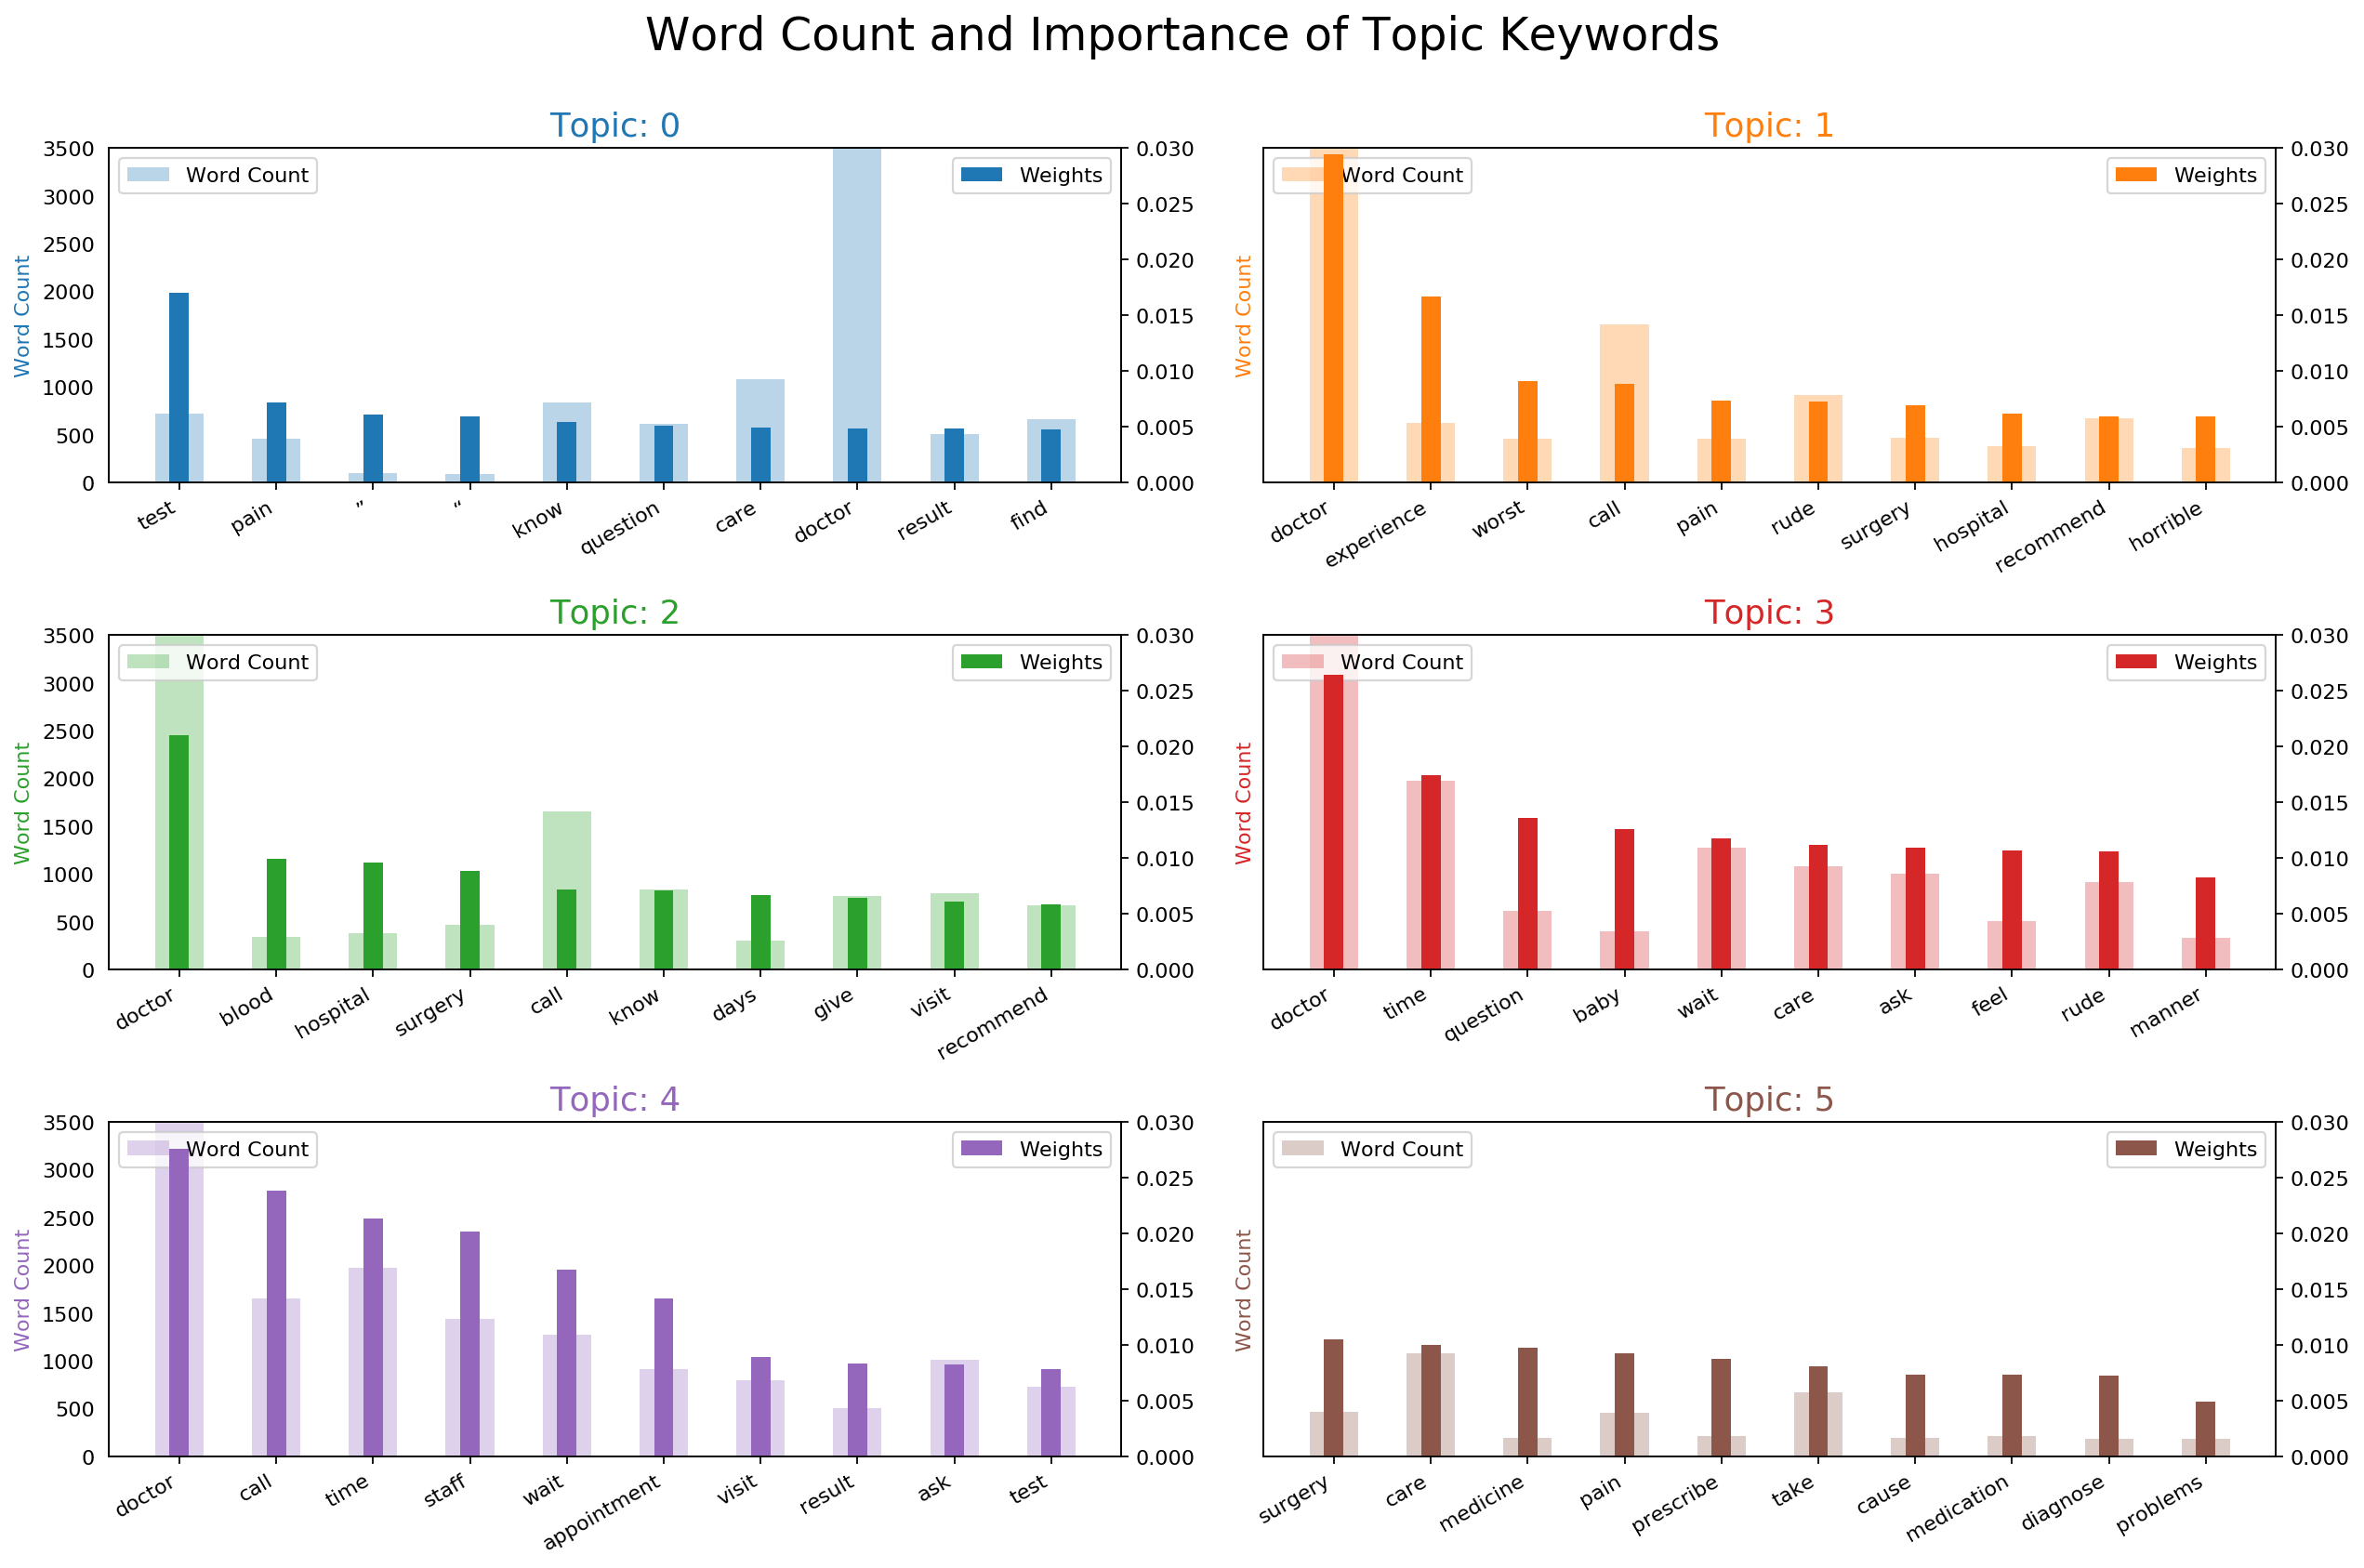

In [58]:
topics = ldamodel_b.show_topics(formatted=False)
data_flat = [w for w_list in clean_rvws_b_new for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
   for word, weight in topic:
       out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = pyplot.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
   ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
   ax_twin = ax.twinx()
   ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
   ax.set_ylabel('Word Count', color=cols[i])
   ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
   ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
   ax.tick_params(axis='y', left=False)
   ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
   ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
pyplot.show()


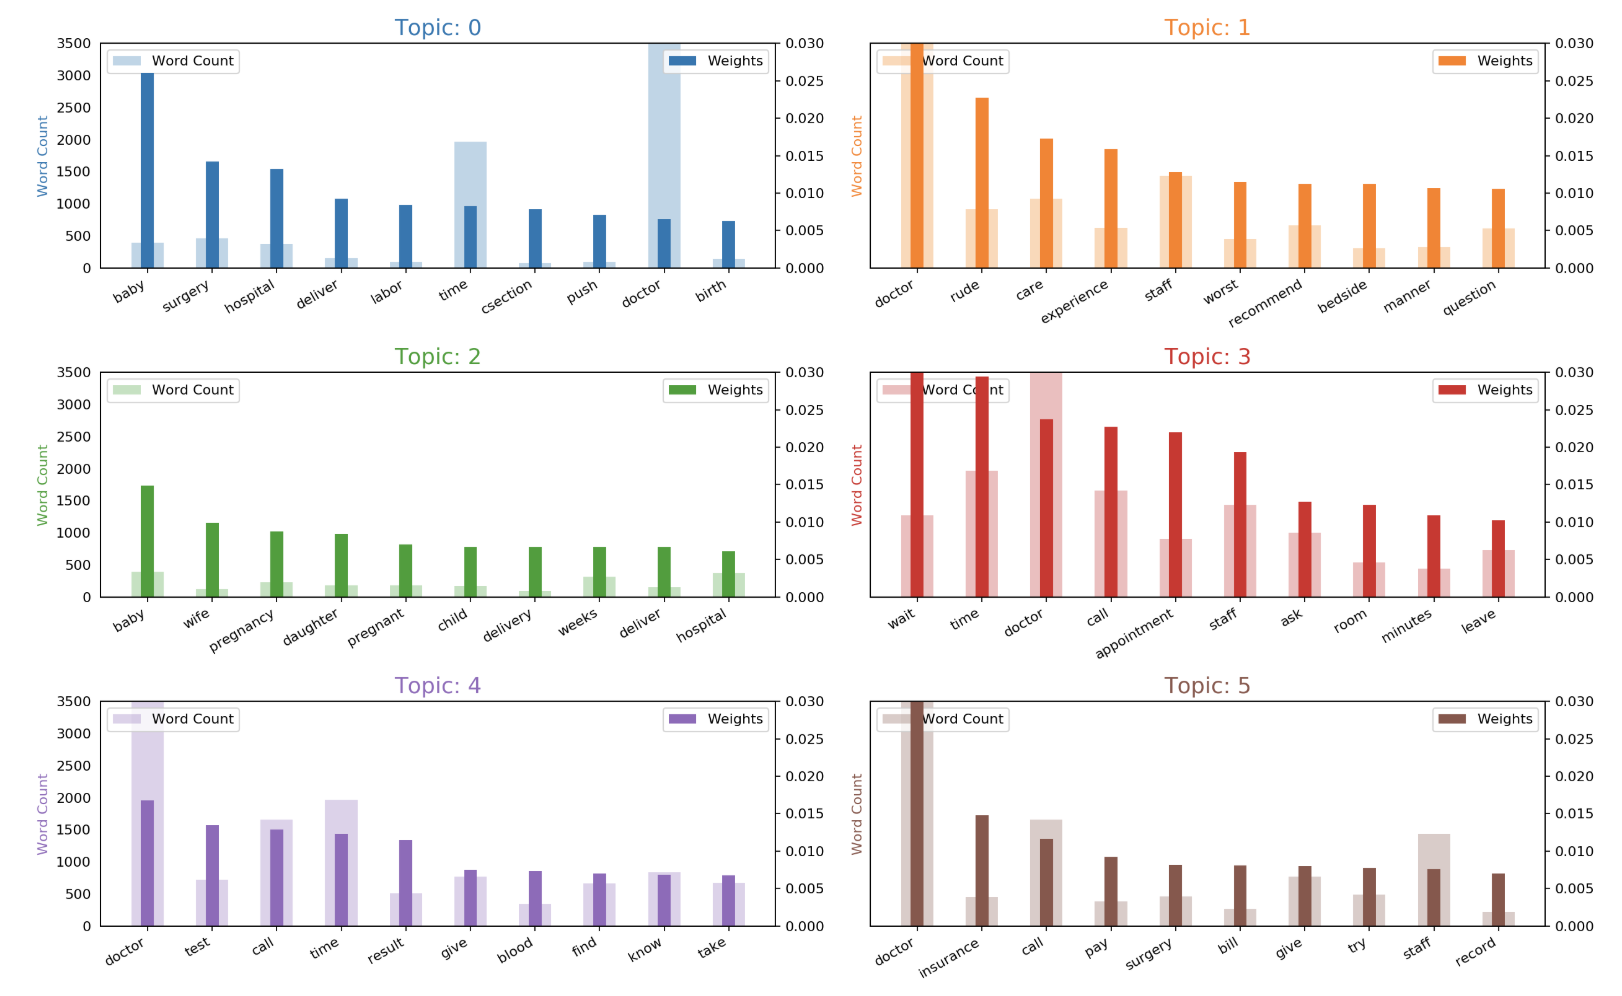

In [59]:
pyLDAvis.enable_notebook()
vis_b = pyLDAvis.gensim.prepare(ldamodel_b, doc_term_matrix_b, dictionary=ldamodel_b.id2word)

In [65]:
vis_b

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.088815 -0.017772       1        1  28.552574
3     -0.152314  0.057845       2        1  22.727863
5     -0.060265 -0.062779       3        1  18.773136
1     -0.102323 -0.025771       4        1  16.522970
0      0.173792  0.184102       5        1   7.088827
2      0.229925 -0.135625       6        1   6.334630, topic_info=      Category         Freq              Term        Total  loglift  logprob
152    Default  1212.000000              wait  1212.000000  30.0000  30.0000
2      Default   820.000000       appointment   820.000000  29.0000  29.0000
3380   Default   422.000000              baby   422.000000  28.0000  28.0000
85     Default   839.000000              rude   839.000000  27.0000  27.0000
10     Default  1549.000000              call  1549.000000  26.0000  26.0000
50     Default   413.000000         insurance   413.000000  25.0000  25.0000
346    Default   452.000000           surgery   452.000000  24.0000  24.0000
233    Default   506.000000              room   506.000000  23.0000  23.0000
230    Default   309.000000              hour   309.000000  22.0000  22.0000
91     Default  1250.000000             staff  1250.000000  21.0000  21.0000
99     Default  1795.000000              time  1795.000000  20.0000  20.0000
254    Default   672.000000              test   672.000000  19.0000  19.0000
285    Default   327.000000          hospital   327.000000  18.0000  18.0000
386    Default   529.000000            result   529.000000  17.0000  17.0000
146    Default   392.000000           minutes   392.000000  16.0000  16.0000
115    Default   294.000000           bedside   294.000000  15.0000  15.0000
29     Default  3253.000000            doctor  3253.000000  14.0000  14.0000
145    Default   308.000000            manner   308.000000  13.0000  13.0000
198    Default   656.000000          question   656.000000  12.0000  12.0000
34     Default   651.000000        experience   651.000000  11.0000  11.0000
135    Default   439.000000             worst   439.000000  10.0000  10.0000
747    Default   308.000000             blood   308.000000   9.0000   9.0000
70     Default   345.000000               pay   345.000000   8.0000   8.0000
3197   Default   287.000000         pregnancy   287.000000   7.0000   7.0000
6      Default   239.000000              bill   239.000000   6.0000   6.0000
4944   Default   156.000000           deliver   156.000000   5.0000   5.0000
231    Default   295.000000             hours   295.000000   4.0000   4.0000
42     Default   358.000000          horrible   358.000000   3.0000   3.0000
79     Default   225.000000            record   225.000000   2.0000   2.0000
12     Default   956.000000              care   956.000000   1.0000   1.0000
347     Topic1   149.084244          symptoms   149.795212   1.2487  -5.5922
2555    Topic1    58.341045             smear    59.051212   1.2413  -6.5304
2261    Topic1    49.292133              cyst    50.006123   1.2390  -6.6990
692     Topic1    46.824268          abnormal    47.536312   1.2383  -6.7504
567     Topic1    41.130127            throat    41.839558   1.2363  -6.8800
2702    Topic1    38.200970             focus    38.912609   1.2350  -6.9539
10482   Topic1    36.305050               hpv    37.012928   1.2341  -7.0048
1939    Topic1    32.904091                rx    33.614567   1.2321  -7.1032
755     Topic1    30.308826            sample    31.019541   1.2302  -7.1853
8989    Topic1    27.361315           jackson    28.072100   1.2278  -7.2876
11461   Topic1    25.915846            varkey    26.623657   1.2265  -7.3419
3812    Topic1    25.855009              dose    26.565756   1.2263  -7.3442
1888    Topic1    24.795160              fall    25.508099   1.2251  -7.3861
3226    Topic1    24.375534        particular    25.085526   1.2247  -7.4032
5558    Topic1    23.313578           genital    24.023928  

### Conclusion
Implementing **word frequency** analysis, and **Fisher's Discriminant Scores**, we were able to identify the most frequent and discriminating words between good and bad reviews. Using **WordtoVec** and **LDA**, we were then able to find the most imortant topics that were in either the good or bad reviews, helping us to understand the context behind the most common words appearing under each category of reviews. 

Our main finding from this analysis is that doctors should focus on the following:
* Having good bedside manner by taking the time to listen to patients and give thorough explainations
* Being personable and caring when interacting with patients
* Ensuring their staff is friendly and professional
* Positive outcomes for surgeries and procedures
* Insurance only comes up in bad reviews

This is an informative analysis for both doctors recently out of medical school and wanting to understand what aspects of their practice would be most impactful on the sentiment of their patients, or for doctors in practice for many years and looking to improve their patient ratings. In either case, doctors having a better understanding of the needs and preferences of their patients can help both the doctors and patients across the United States. 